# Choosing a colorscale

Here we will showcase a few different options for creating colormaps for grids. 

Import the modules

In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path

import geopandas as gpd
import pygmt
import verde as vd

from polartoolkit import fetch, maps, regions, utils

In [2]:
# set default to southern hemisphere for this notebook
os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

Use the PolarToolkit `fetch` module to download the data and return the grid as an xarray.DataArrays

In [3]:
bed = fetch.bedmap2(
    layer="bed",
    region=regions.lake_vostok,
)

## Existing colormap

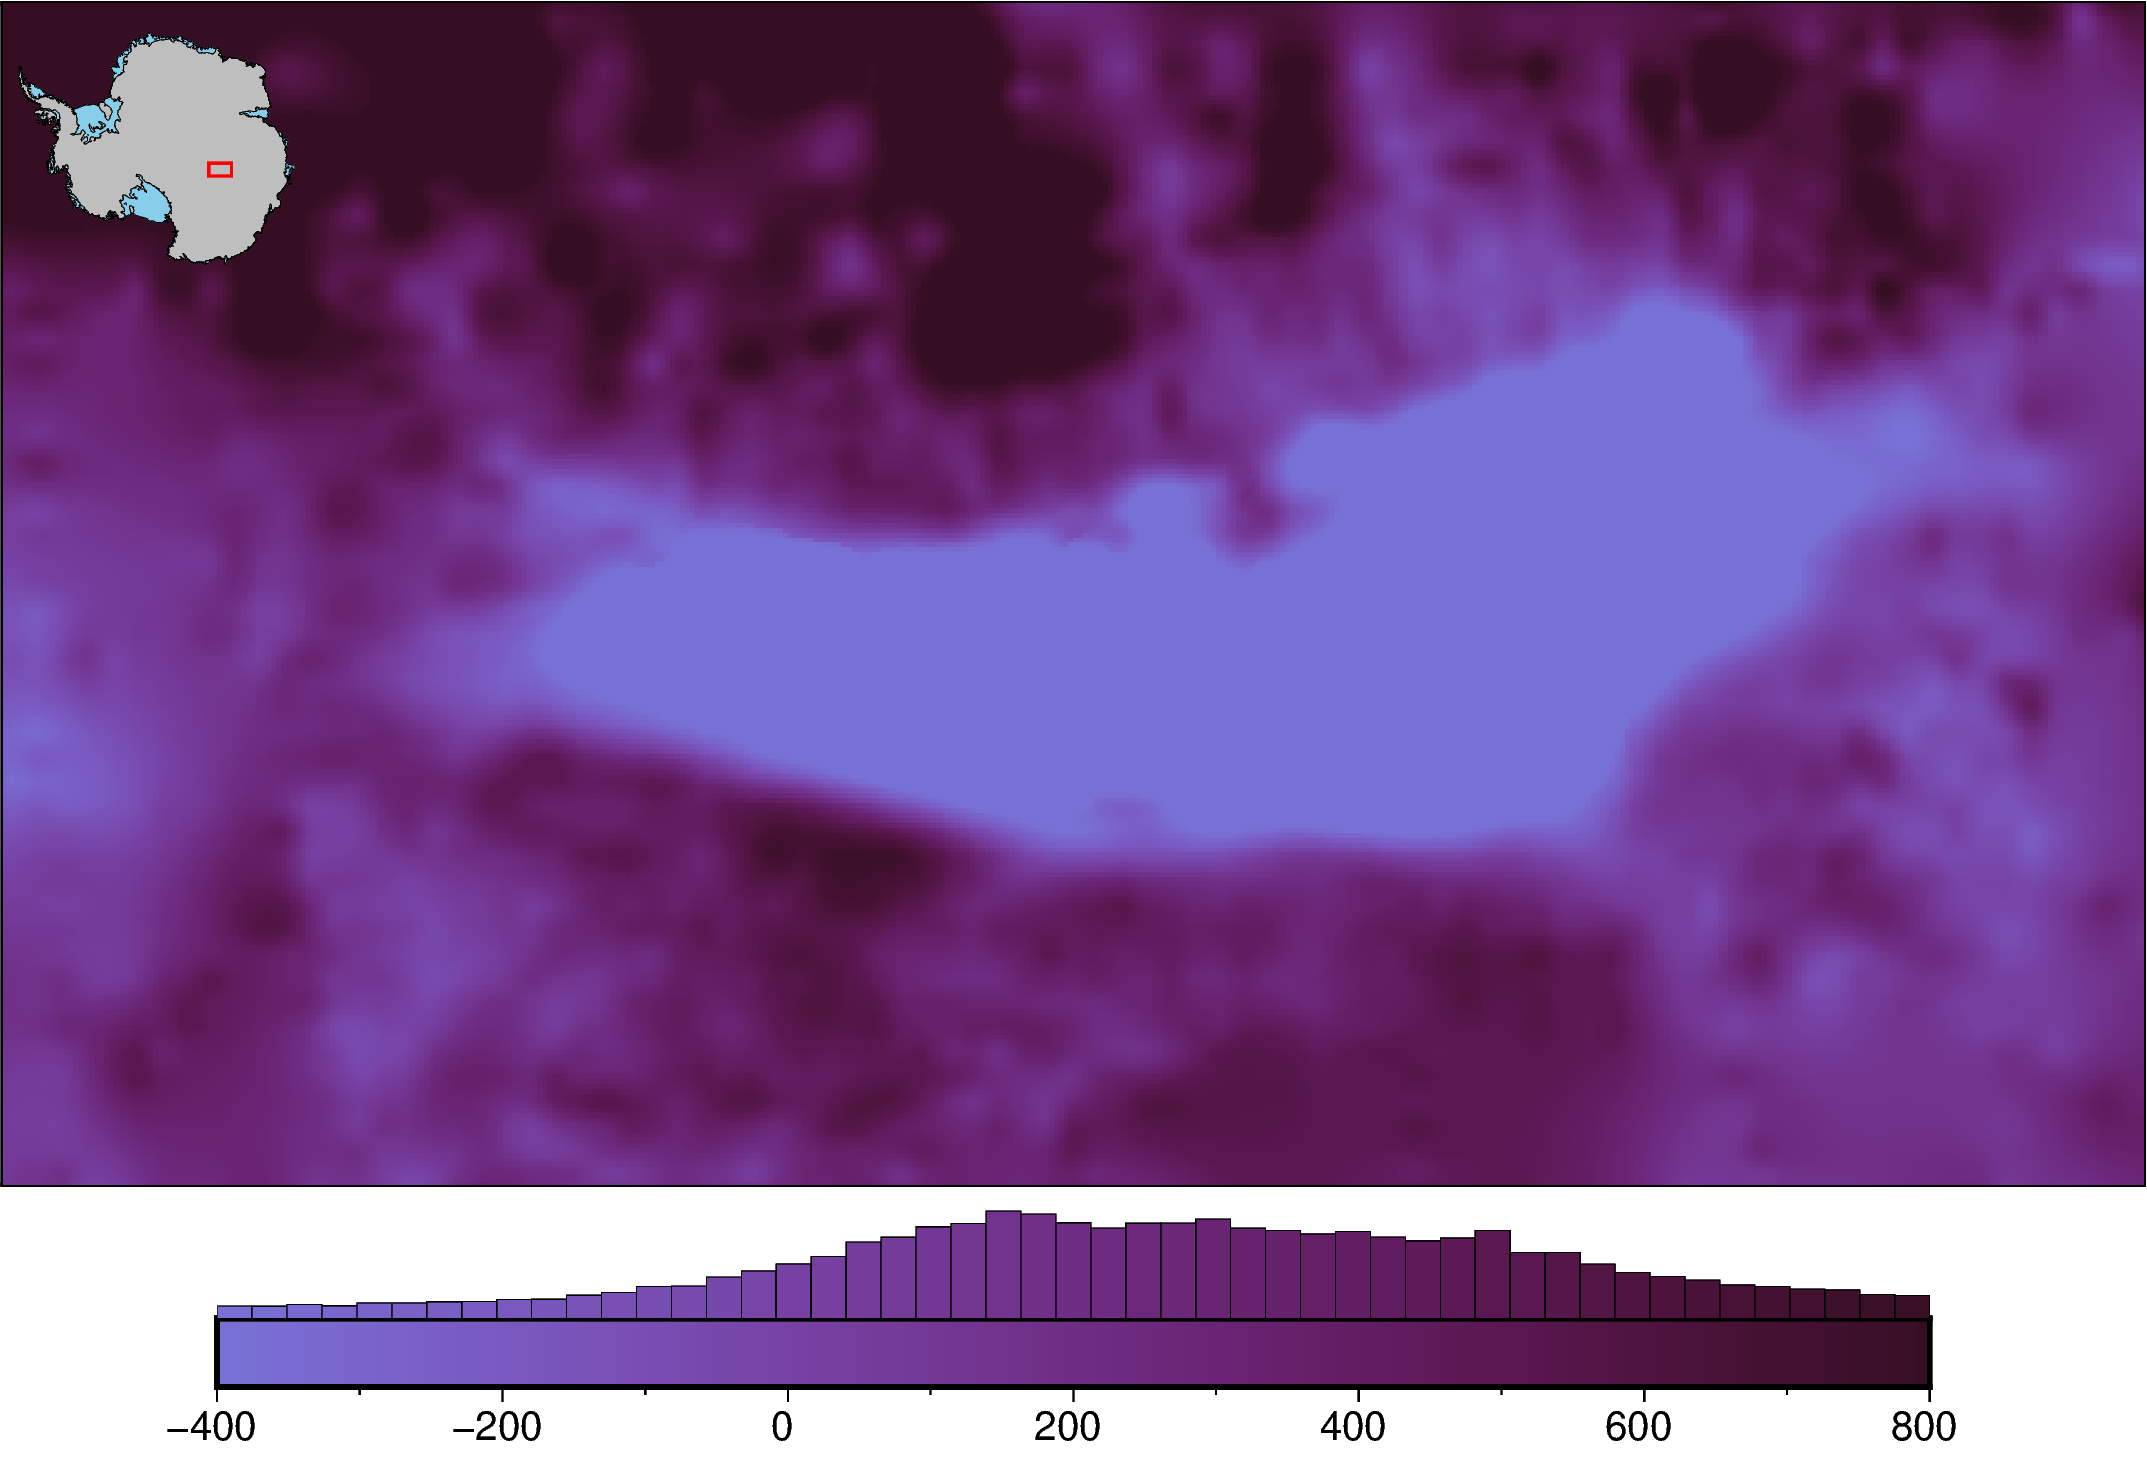

In [4]:
# create and use a .cpt file
pygmt.makecpt(
    cmap="dense",
    series=[-400, 800],  # set limits of grid values
    truncate=[0.5, 1],  # use only a portion of the colorscale
    output="test.cpt",  # name of output file
    background=True,  # make colors outside of range equal to limits
)

fig = maps.plot_grd(
    bed,
    inset=True,
    hist=True,
    cmap="test.cpt",  # use created .cpt file
)

# delete cpt file
Path.unlink("test.cpt")

fig.show(dpi=200)

grd2cpt [WARNING]: matter is a discrete CPT. You can stretch it (-T<min>/<max>) but not interpolate it (-T<min>/<max>/<inc>).


grd2cpt [WARNING]: Selecting the given range and ignoring the increment setting.


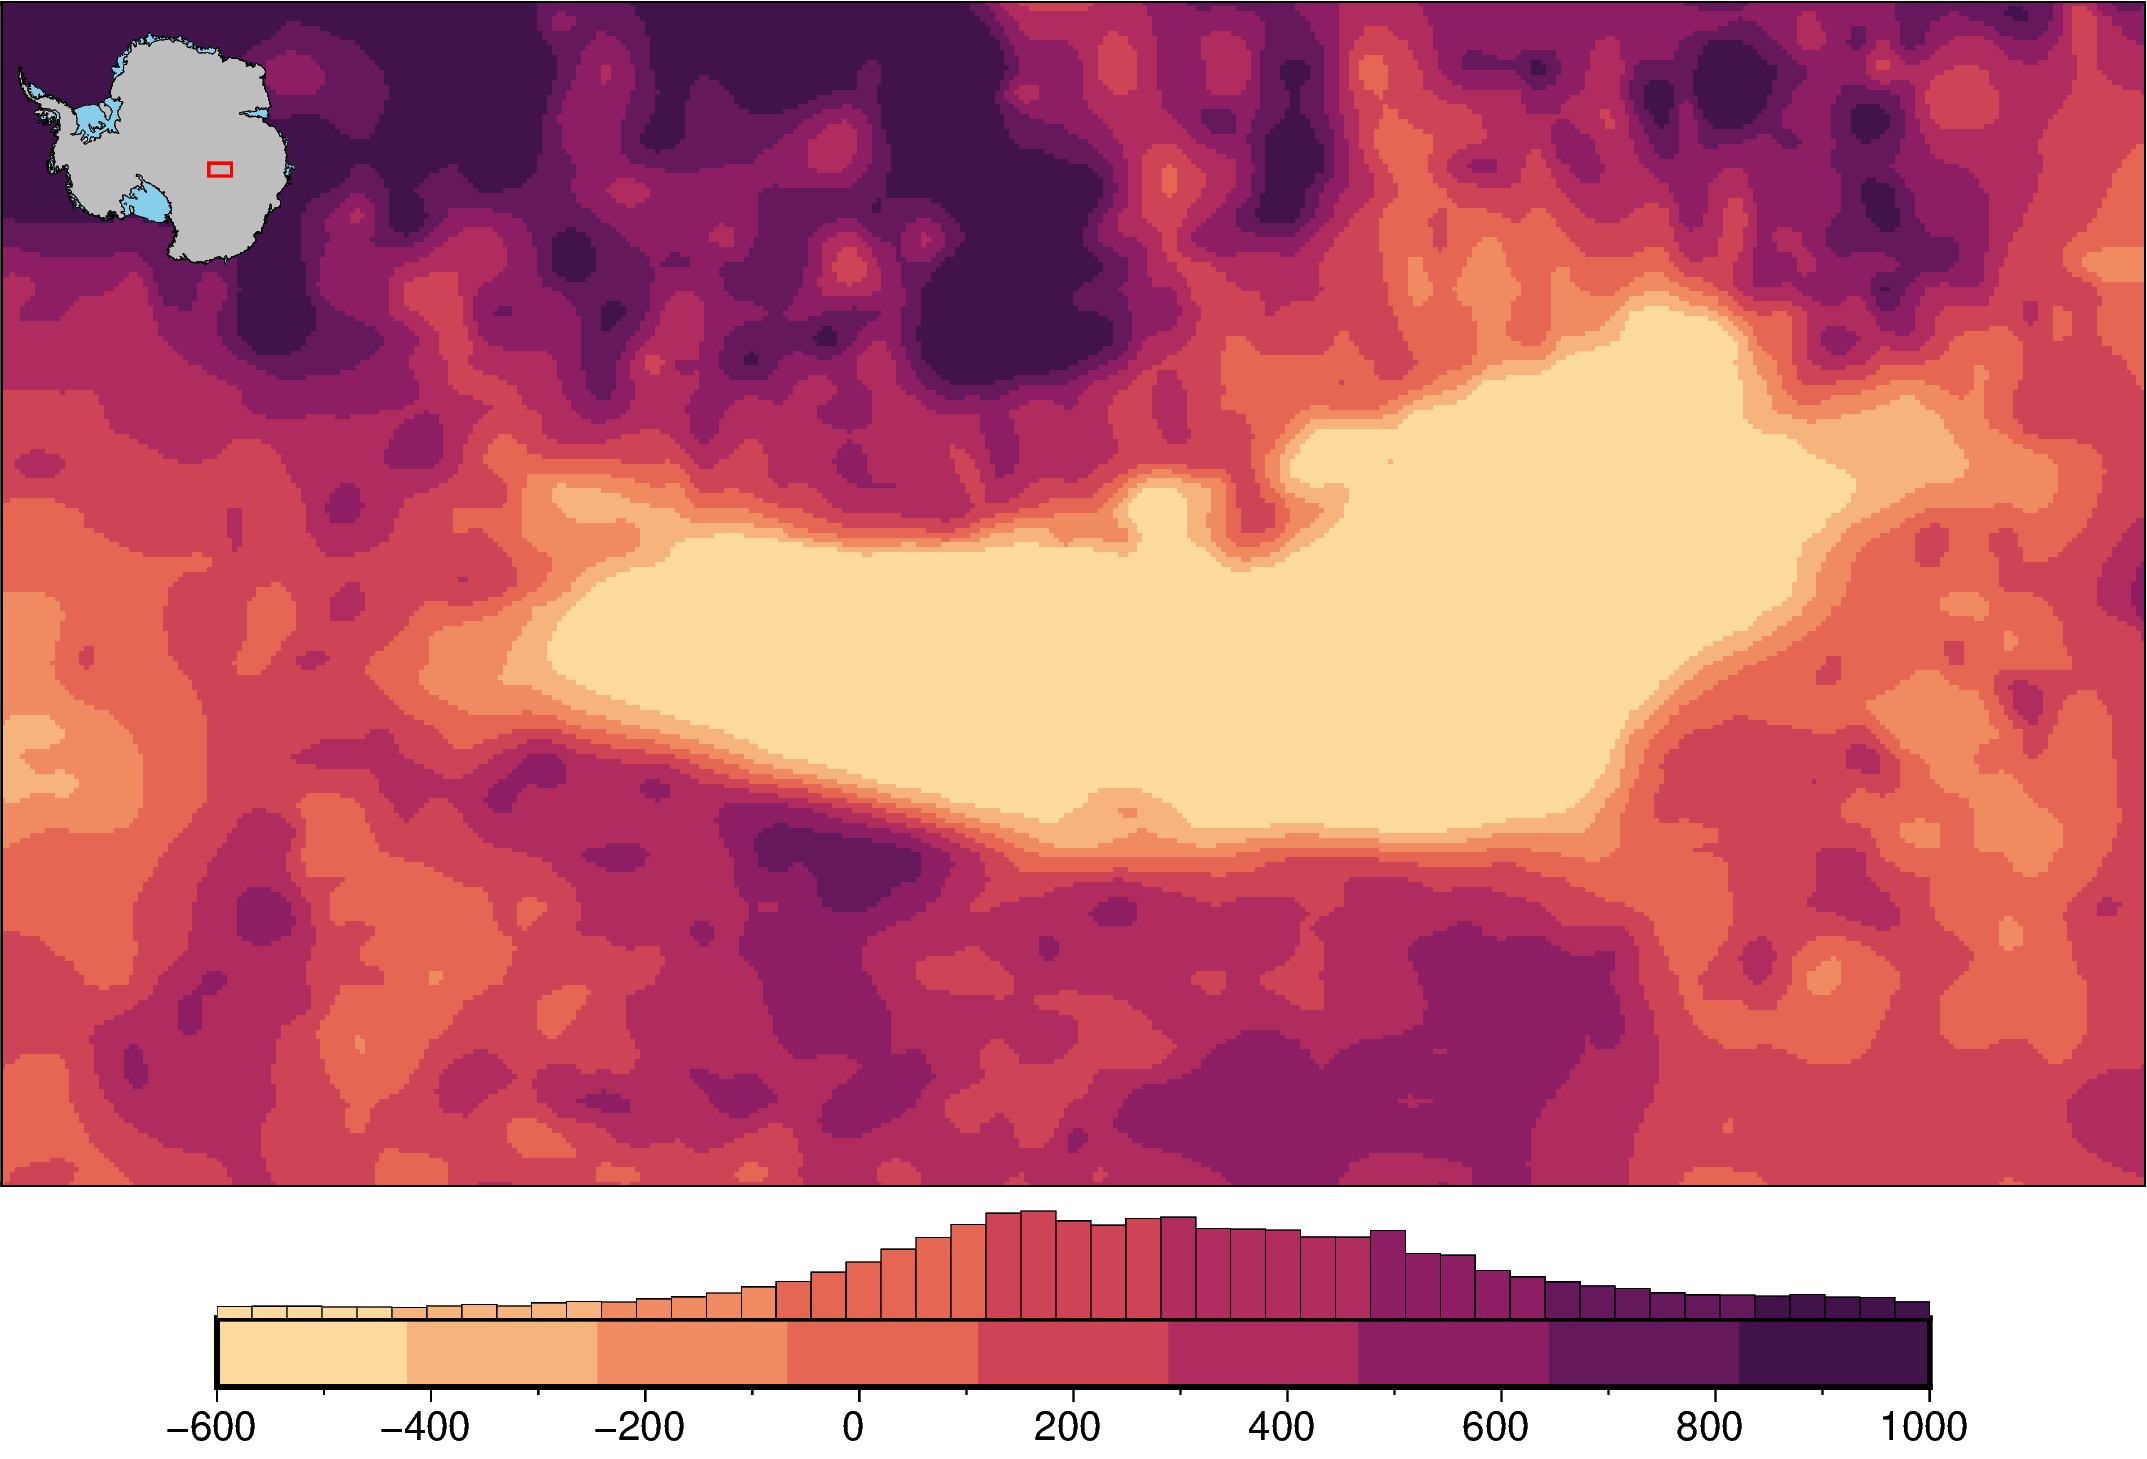

In [5]:
# create a pygmt histogram equalized colormap
pygmt.grd2cpt(
    bed,
    cmap="matter",
    limit=[-600, 1000],  # set limits of grid values
    nlevels=10,  # use 10 discrete colors
    output="test.cpt",  # name of output file
    background=True,  # make colors outside of range equal to limits
)

fig = maps.plot_grd(
    bed,
    inset=True,
    hist=True,
    cmap="test.cpt",  # use created colormap
)

# delete cpt file
Path.unlink("test.cpt")

fig.show(dpi=200)

## Defaults settings

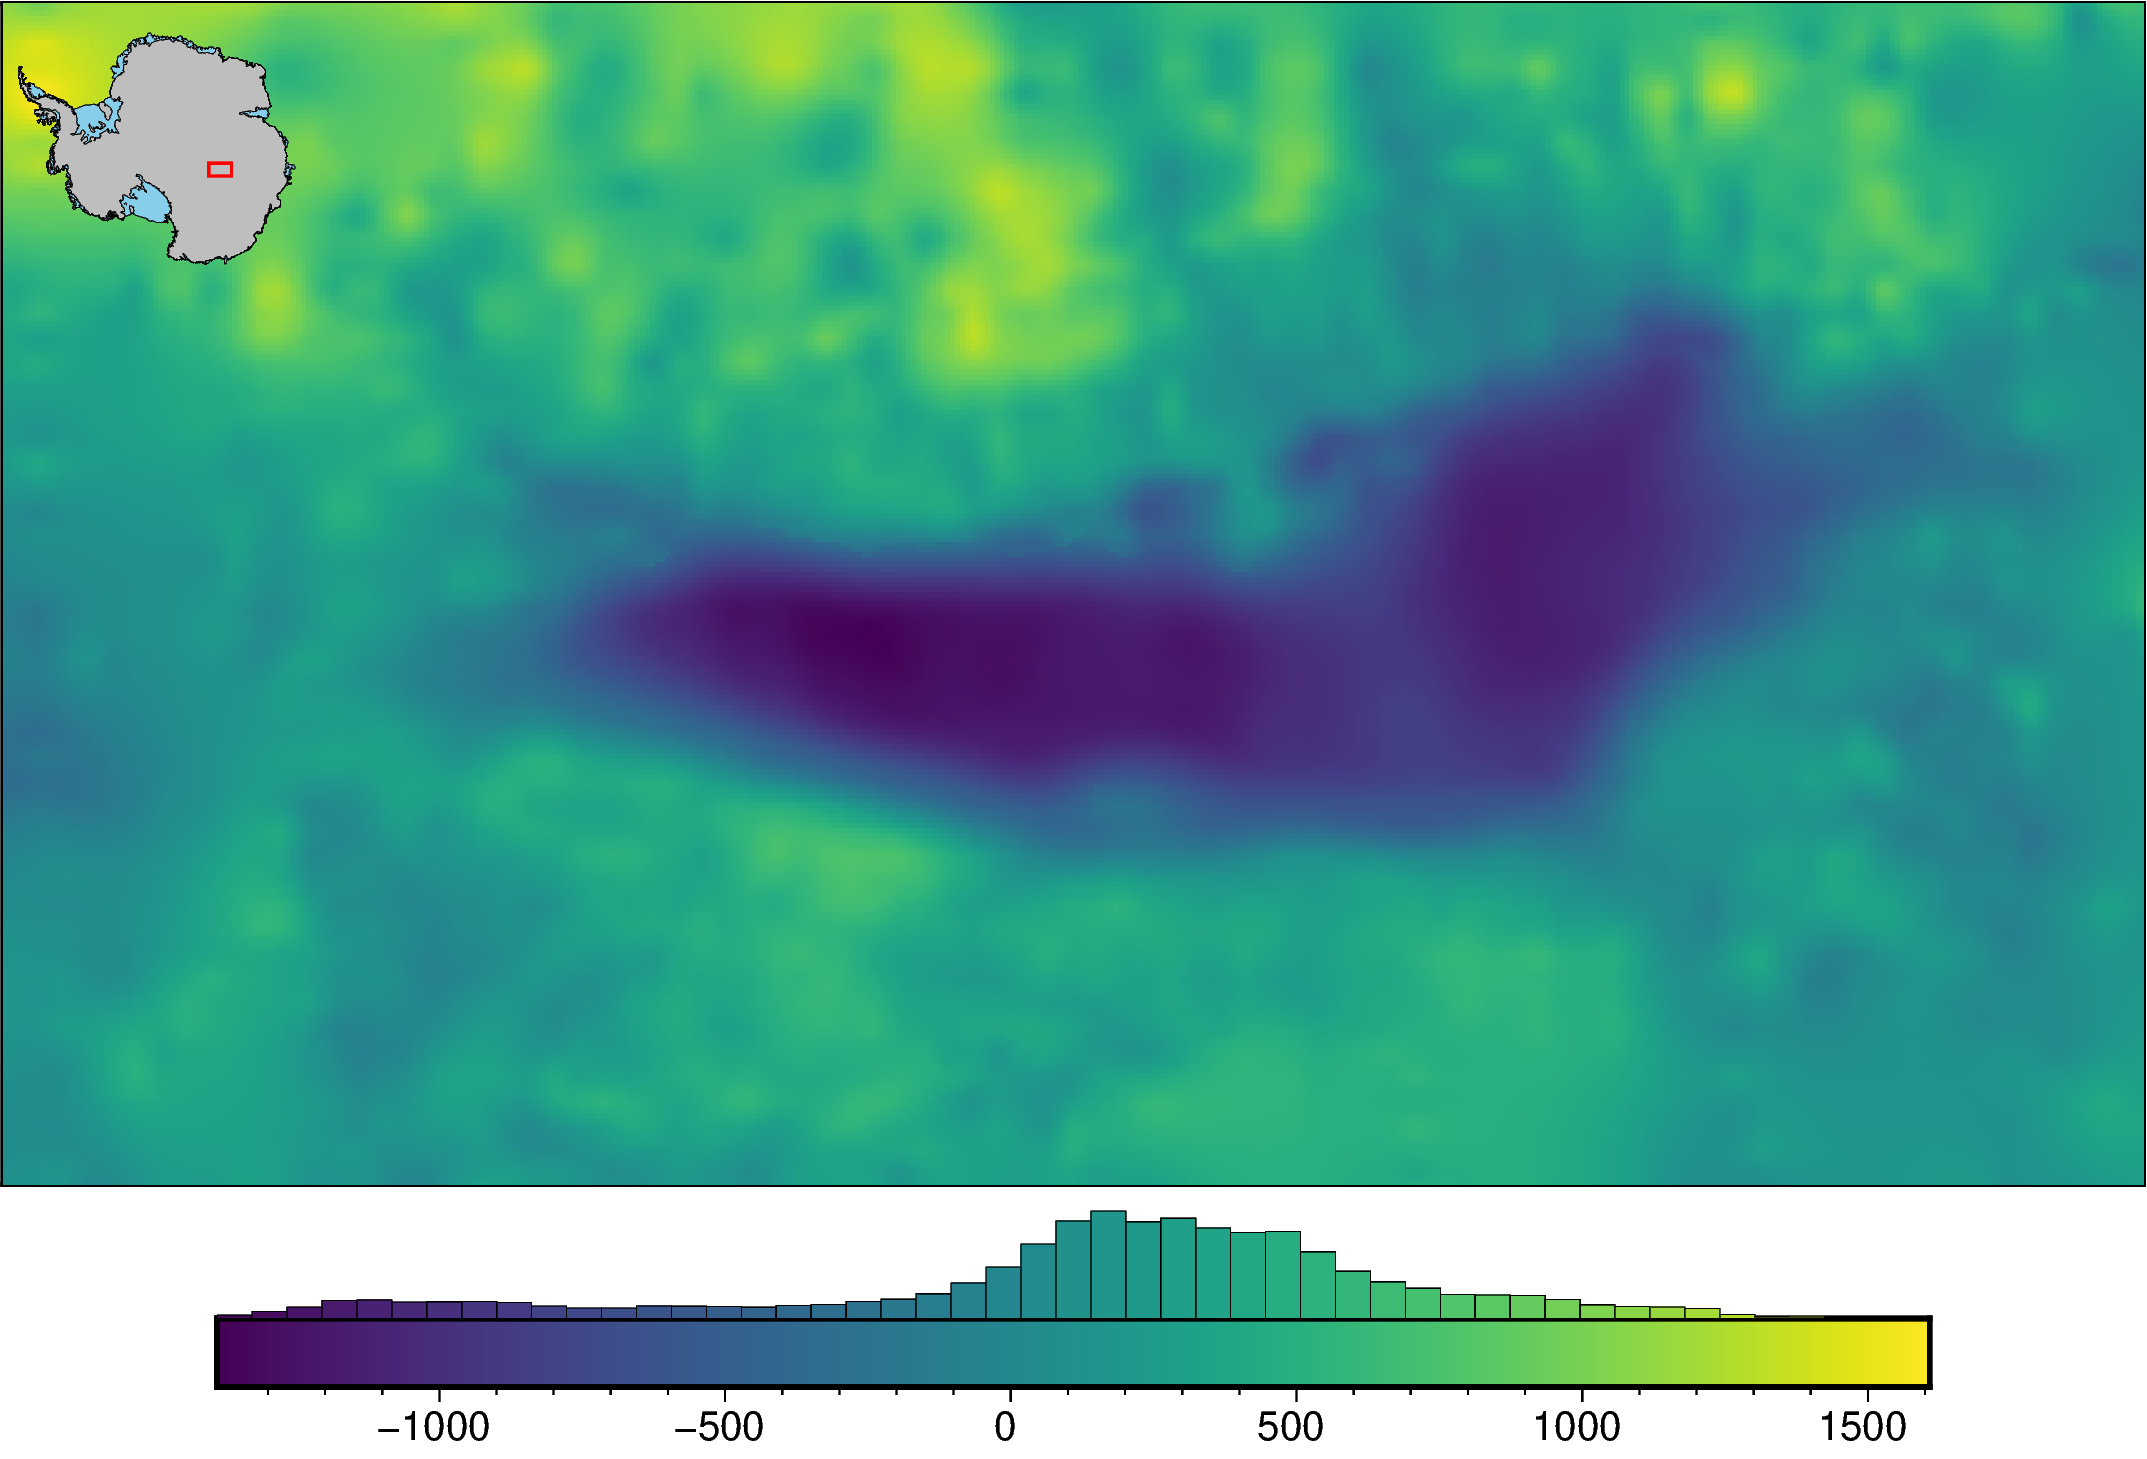

In [6]:
fig = maps.plot_grd(
    bed,
    inset=True,
    hist=True,
)

fig.show(dpi=200)

## Basic options

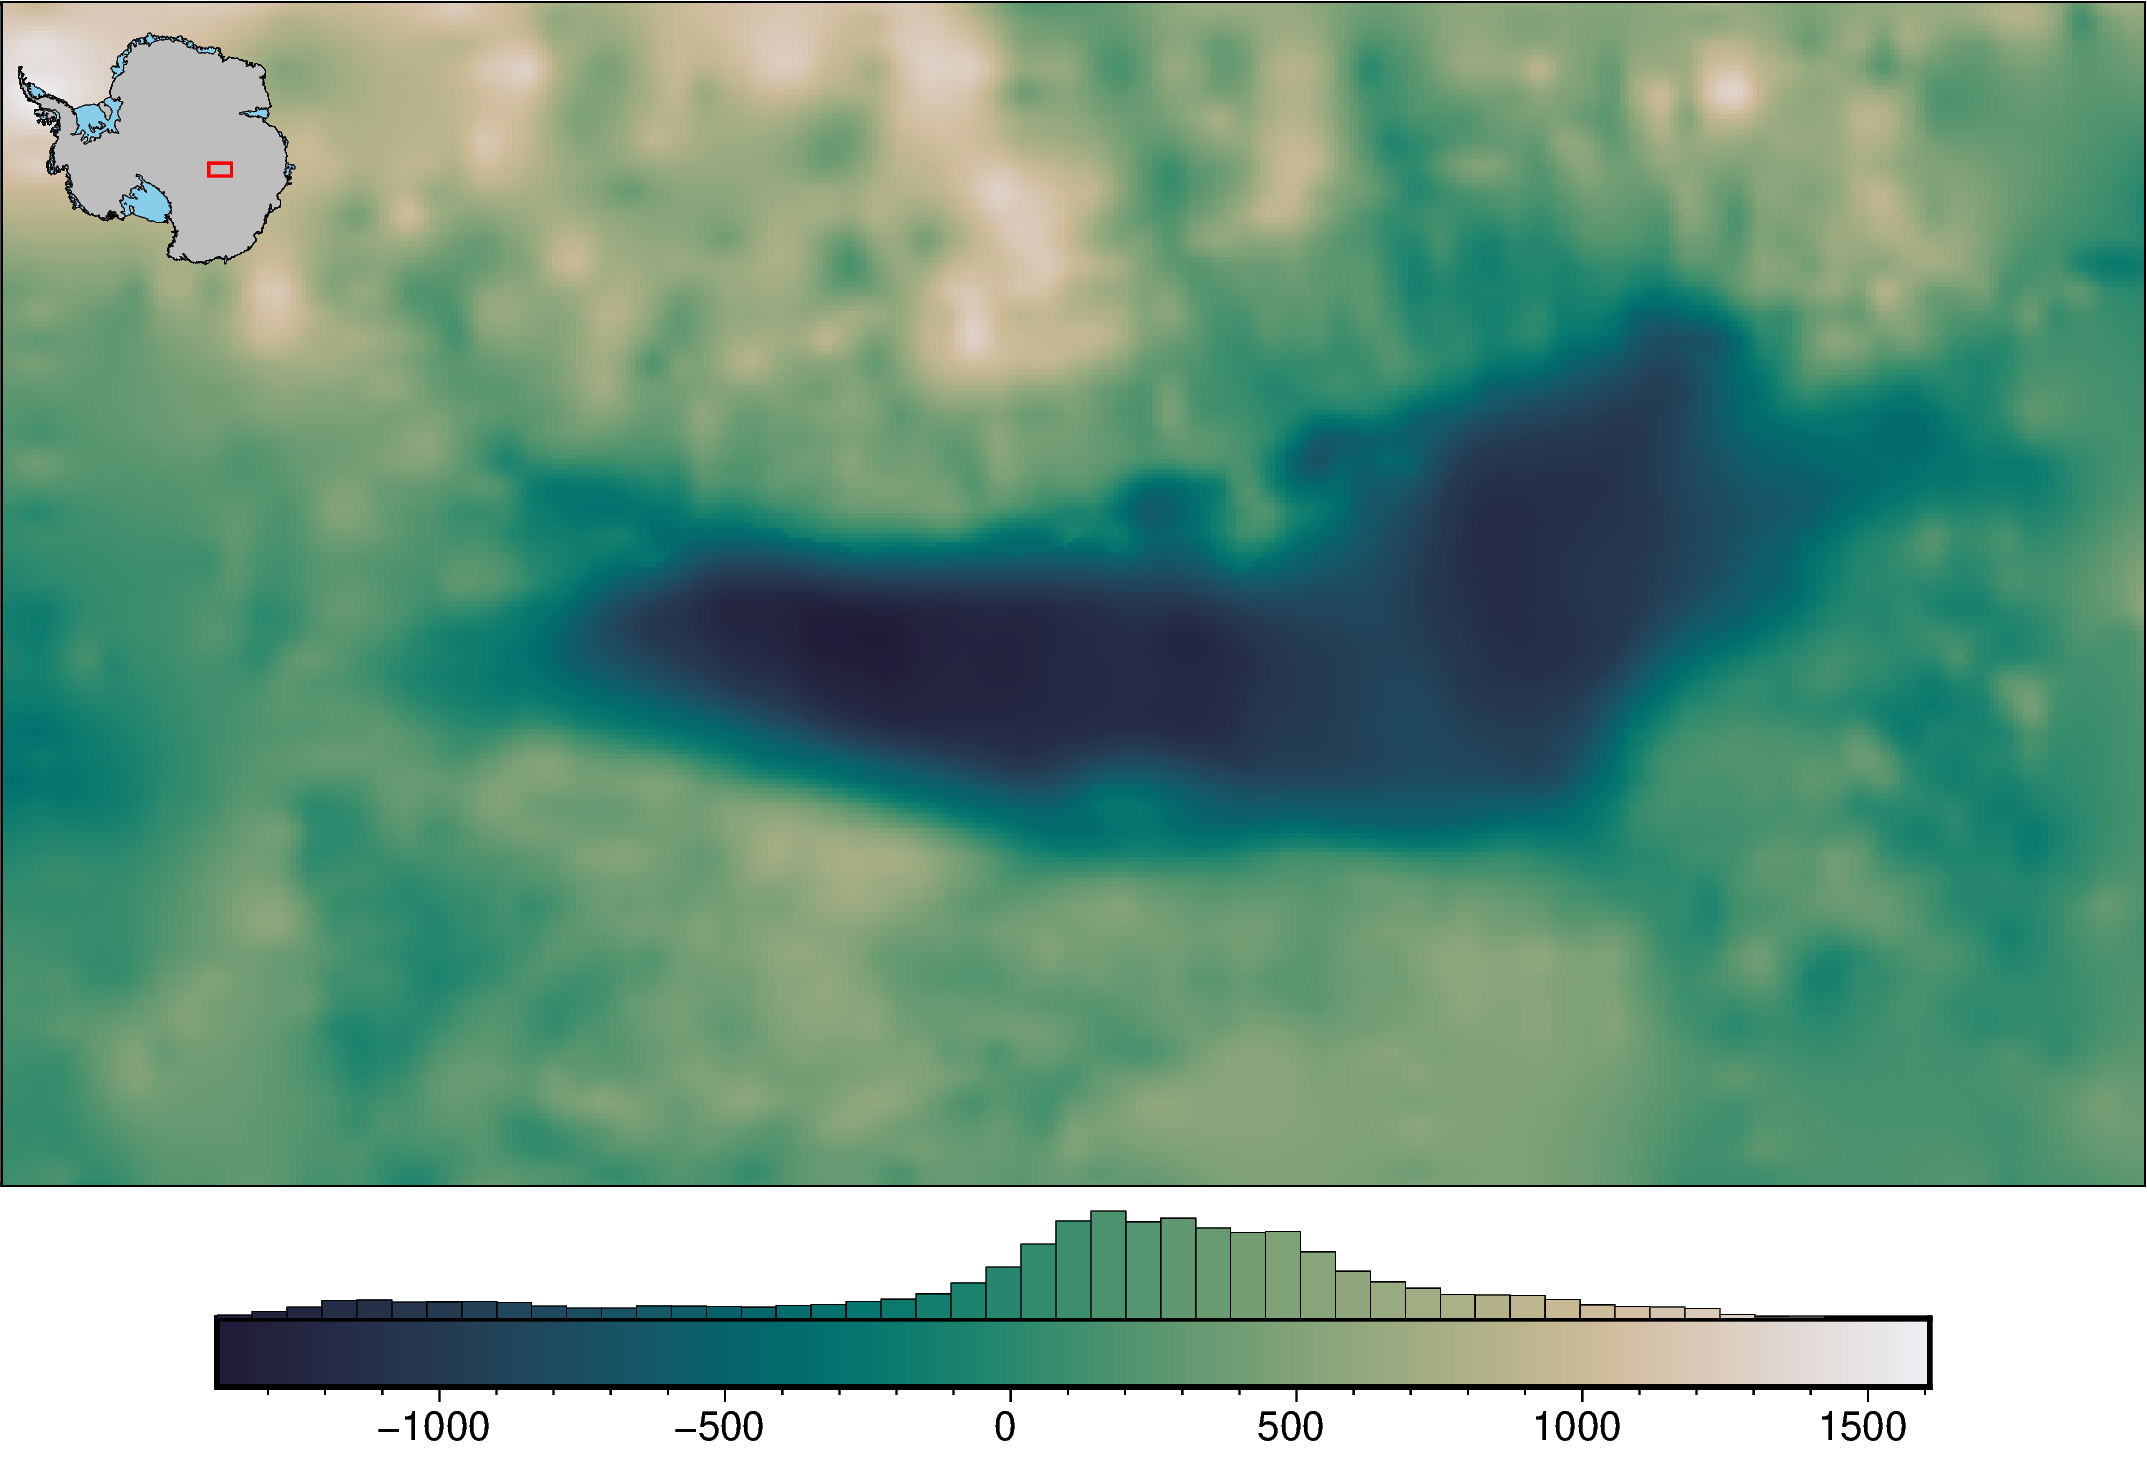

In [7]:
fig = maps.plot_grd(
    bed,
    inset=True,
    hist=True,
    cmap="rain",  # change the colormap
    reverse_cpt=True,  # reverse the colors
)

fig.show(dpi=200)

## Customize color limits

### Manually set limits
Notice that since we are cutting off the large values, a triangle is automatically added on the colorbar to indicate this. This doesn't occur if a .cpt file is passed.

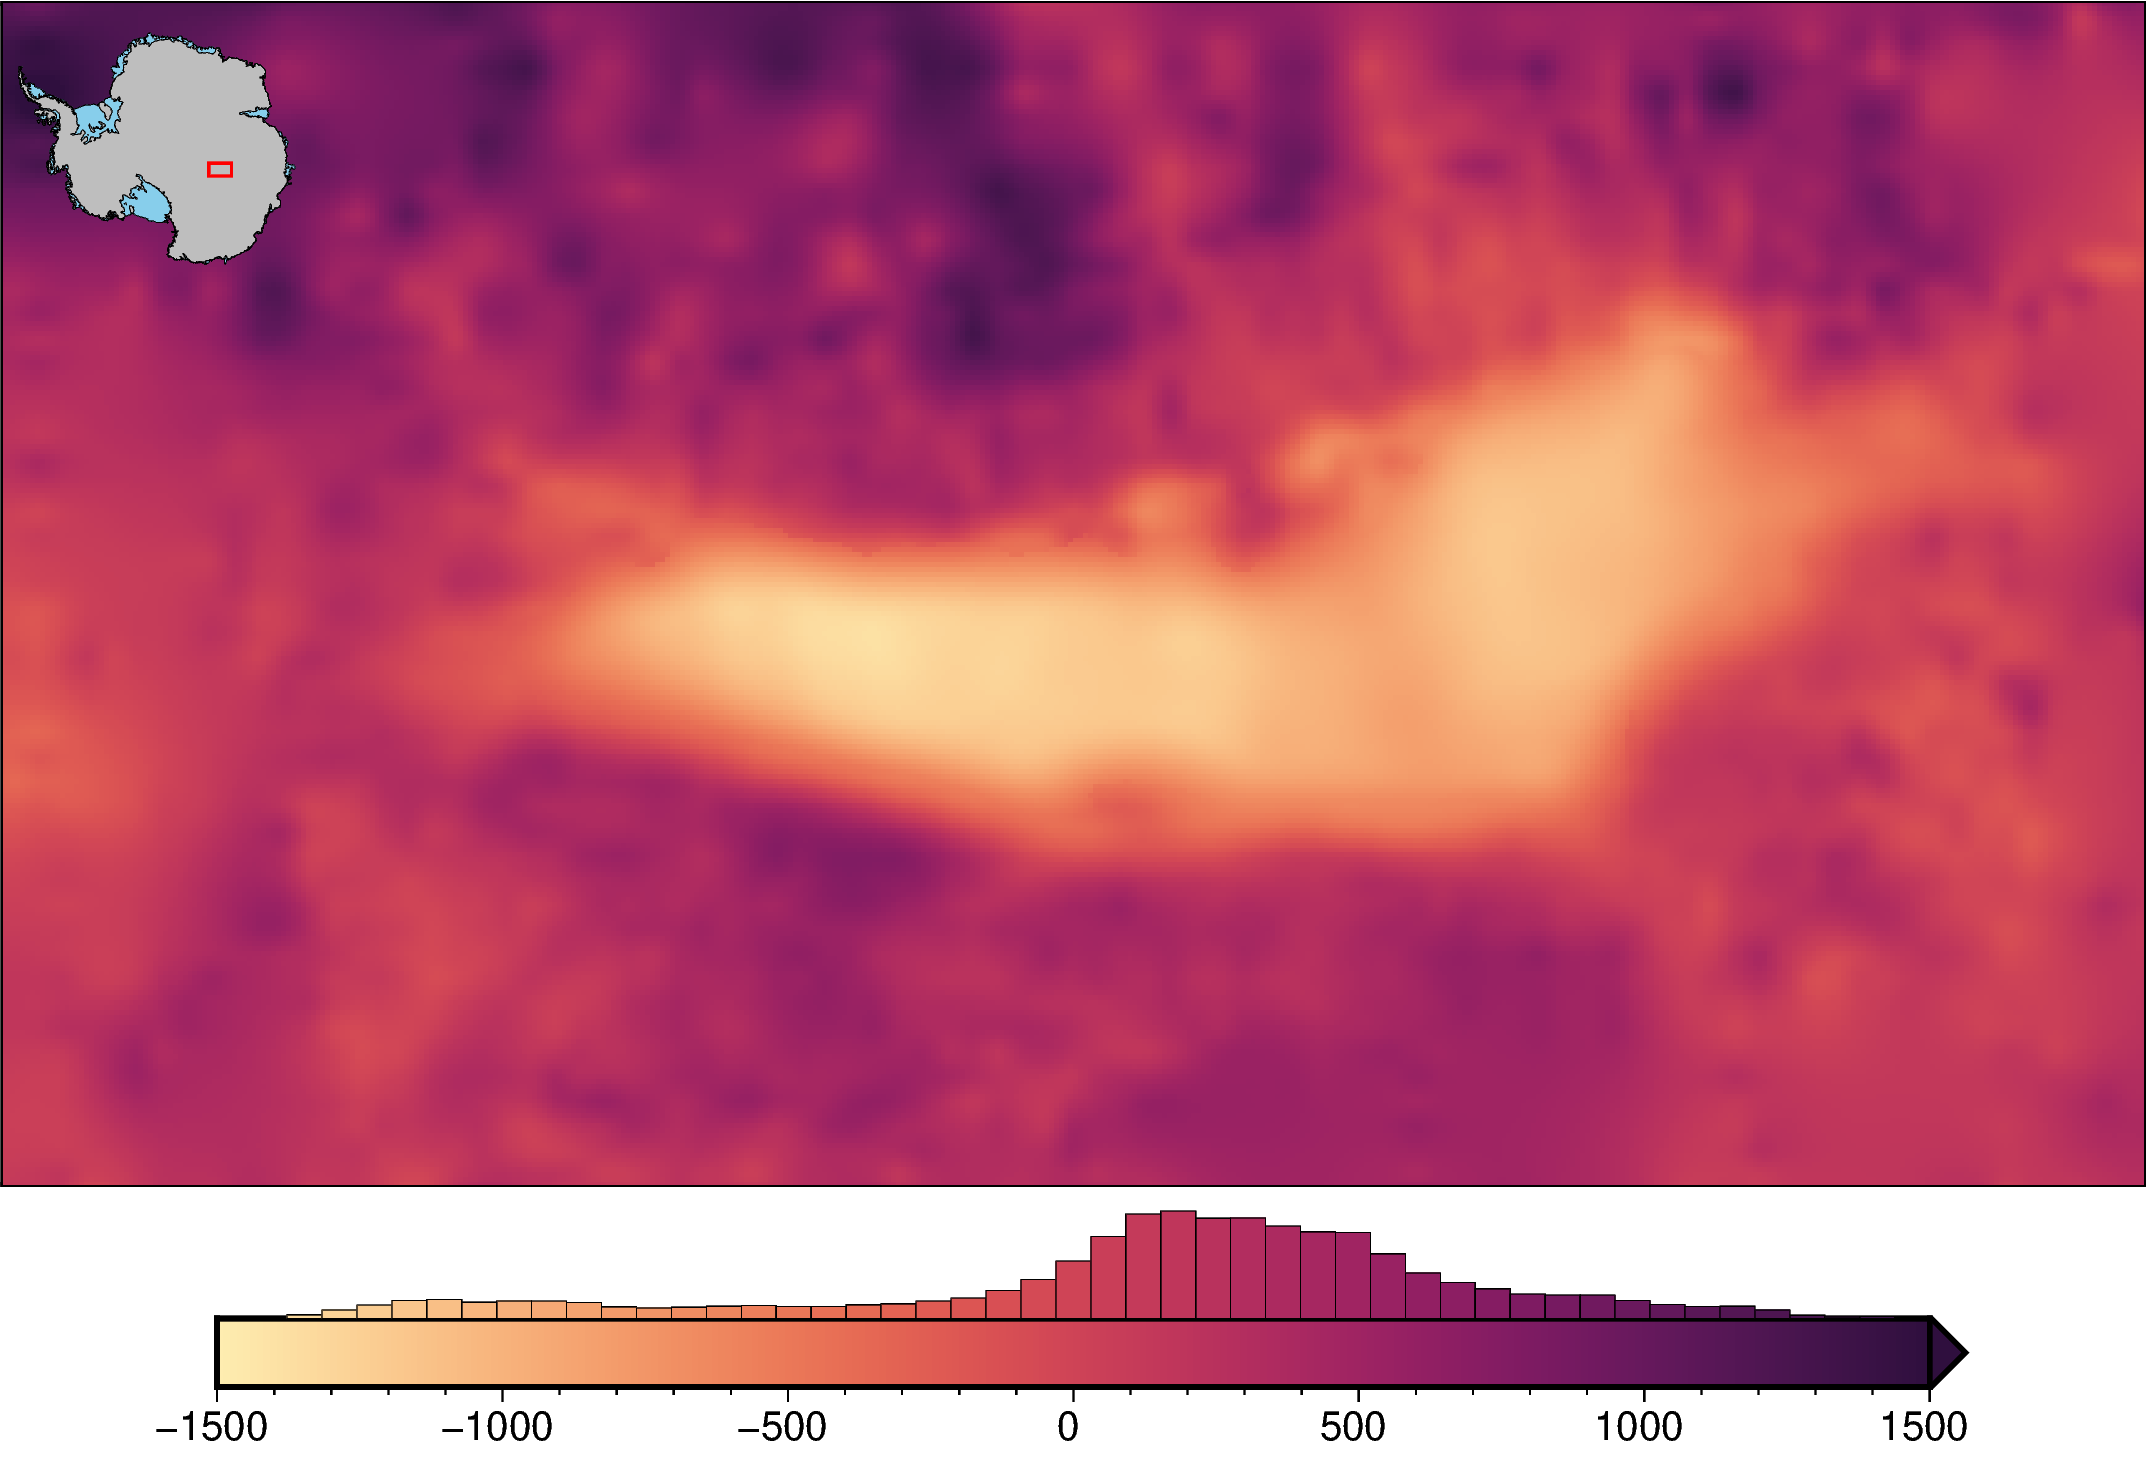

In [8]:
fig = maps.plot_grd(
    bed,
    inset=True,
    hist=True,
    cmap="matter",
    cpt_lims=(-1500, 1500),  # change the colorbar limits
)

fig.show(dpi=200)

### Set "robust" limits
This uses the 2nd and 98th percentiles of the data as the limits to omit outliers. You can set which percentiles are used with 'robust_percentiles', which by default is (0.02, 0.98).

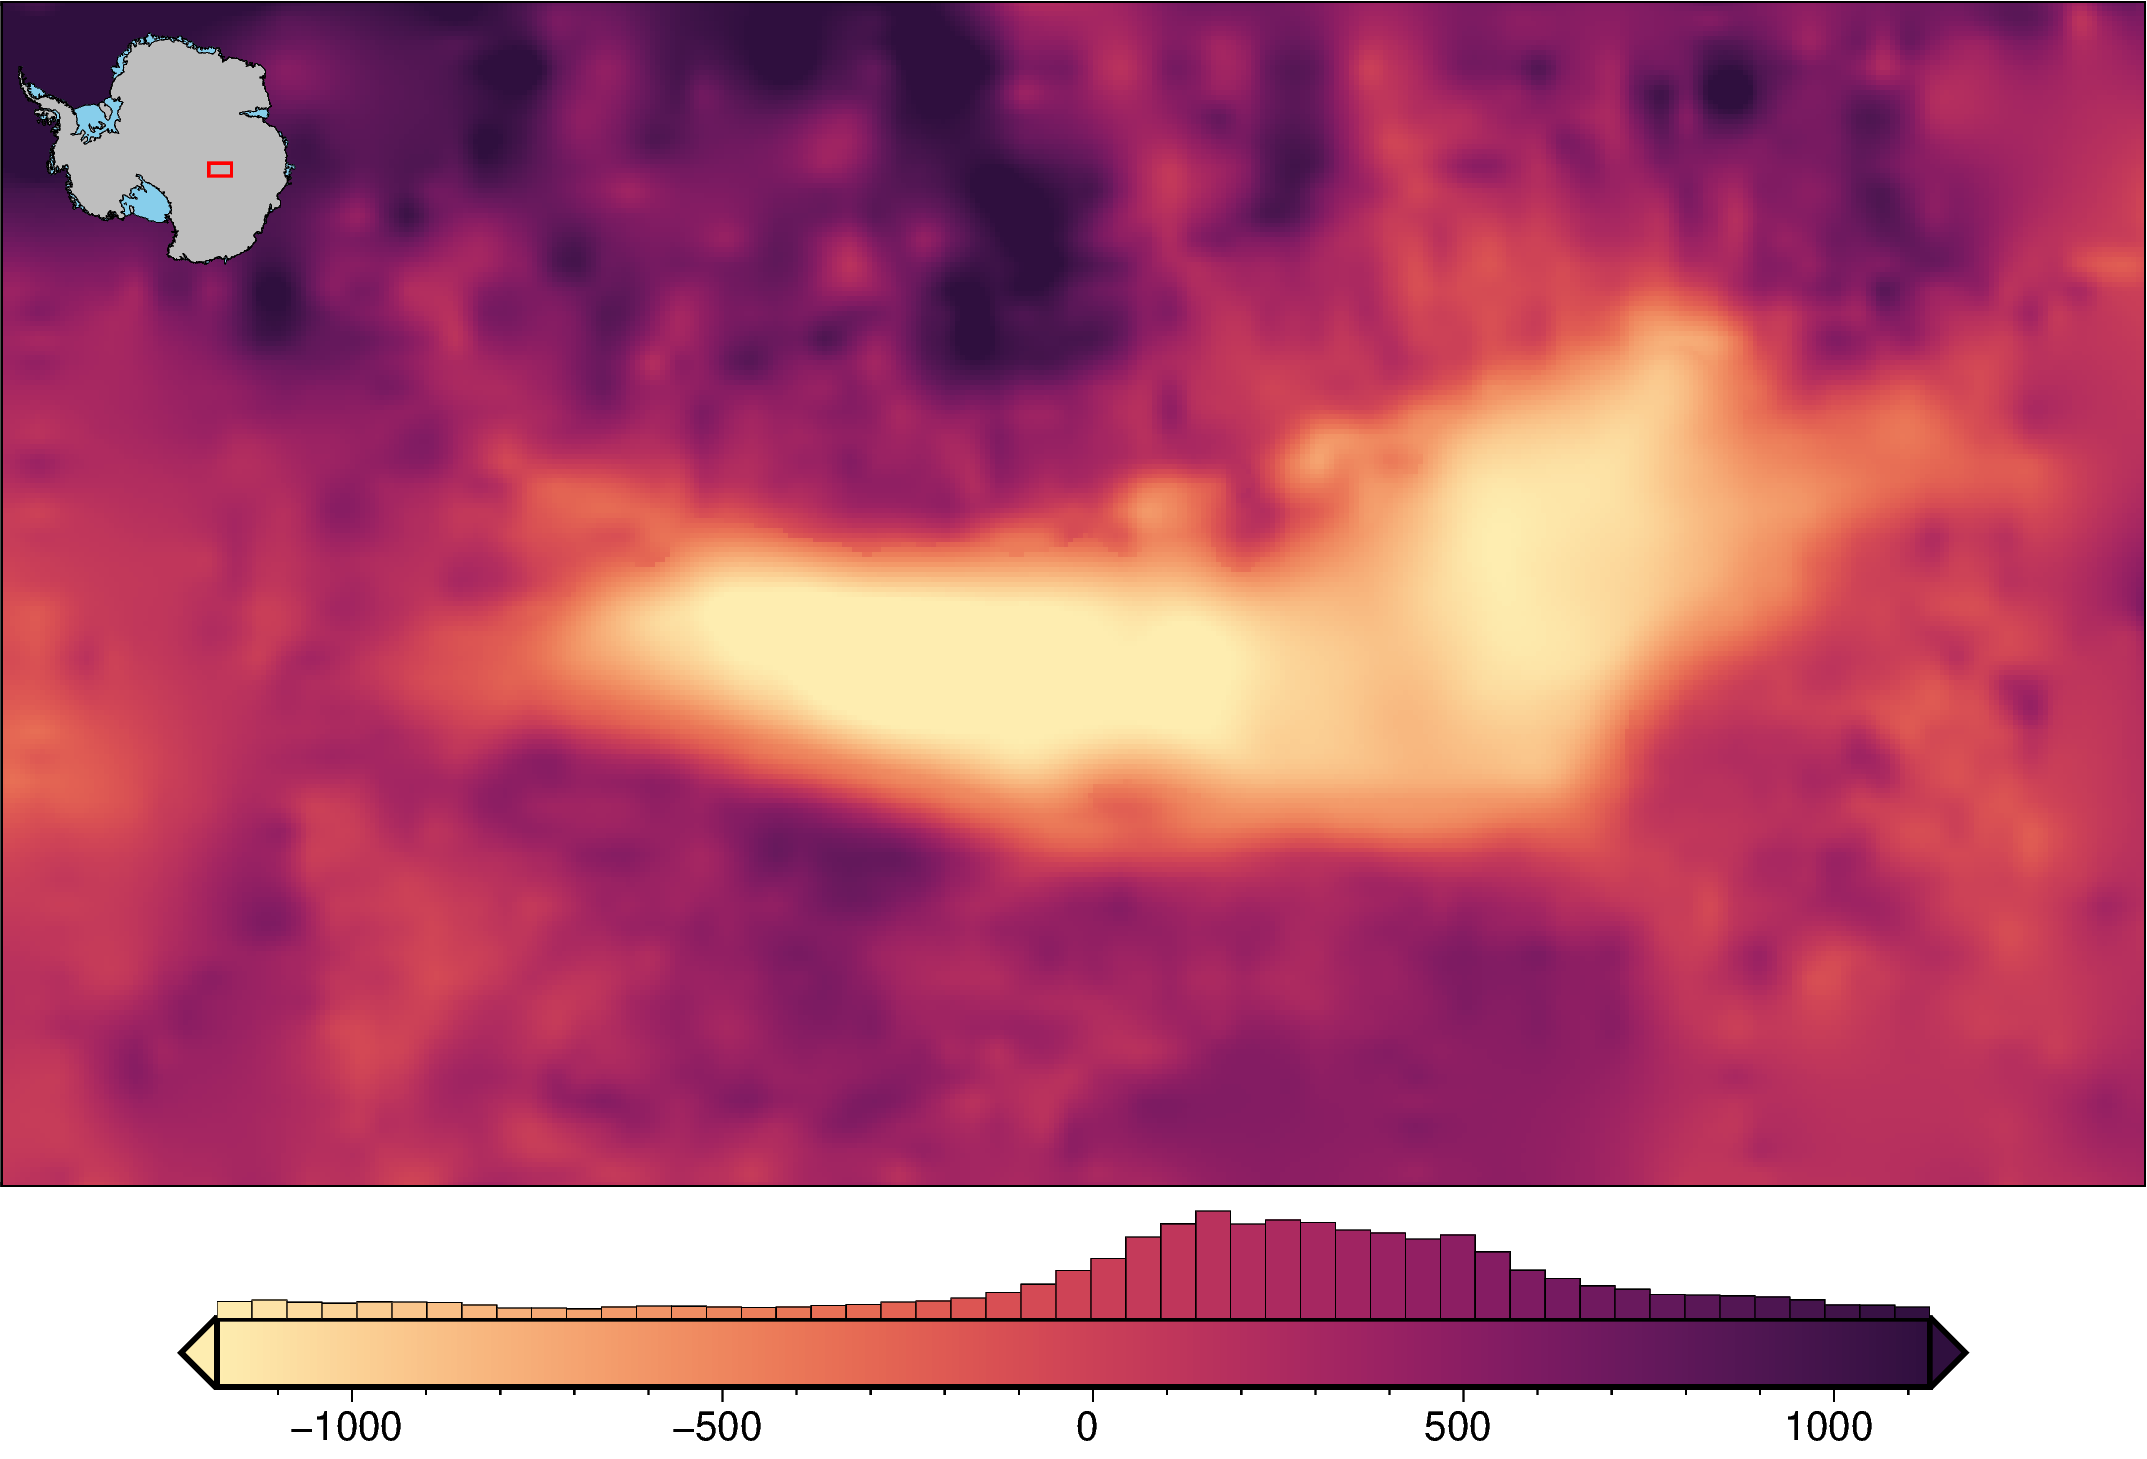

In [9]:
fig = maps.plot_grd(
    bed,
    inset=True,
    hist=True,
    cmap="matter",
    robust=True,  # set the color limits to the 2nd and 98th percentiles of the data
)

fig.show(dpi=200)

### Hinged colormaps
If you want you colormap centered around a specific value, certain colormaps allow adding '+h0' where '0' can be set to the value of the hinge.

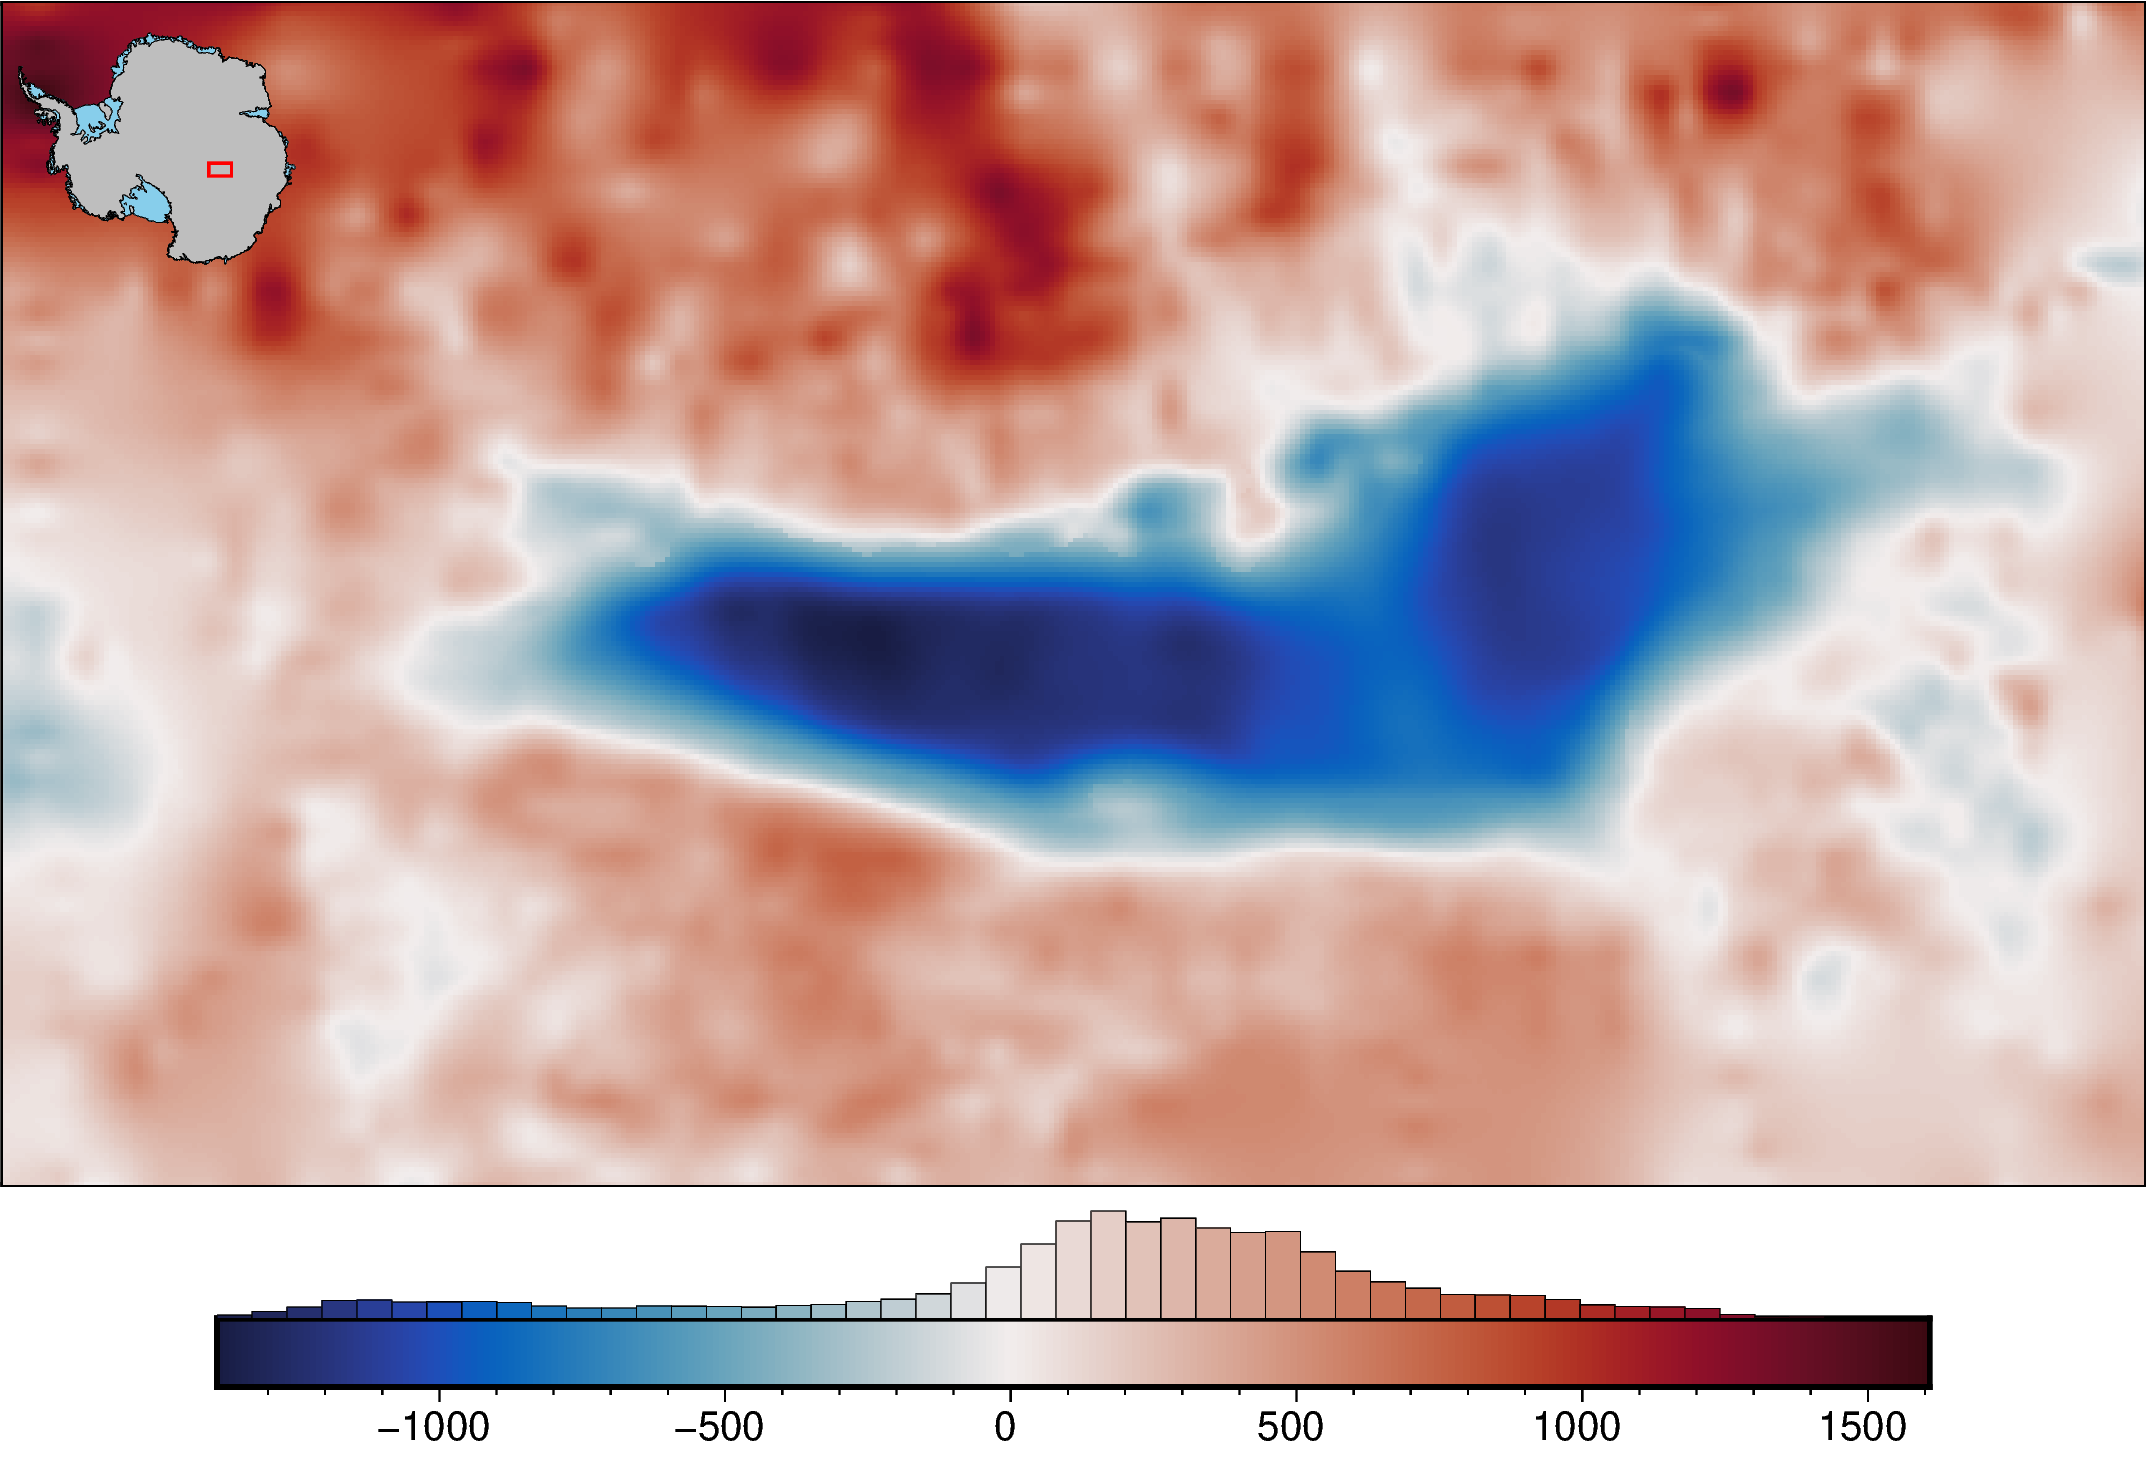

In [10]:
fig = maps.plot_grd(
    bed,
    inset=True,
    hist=True,
    cmap="balance+h0",
)

fig.show(dpi=200)

### Absolute values
In the above plot, while the low values, blues, appear darker and the high values, indicating they are further from the hinge of 0. To fix this, we can set the colorscale limits to equal values. Now the darkness of the blues and reds can be accurately compared.

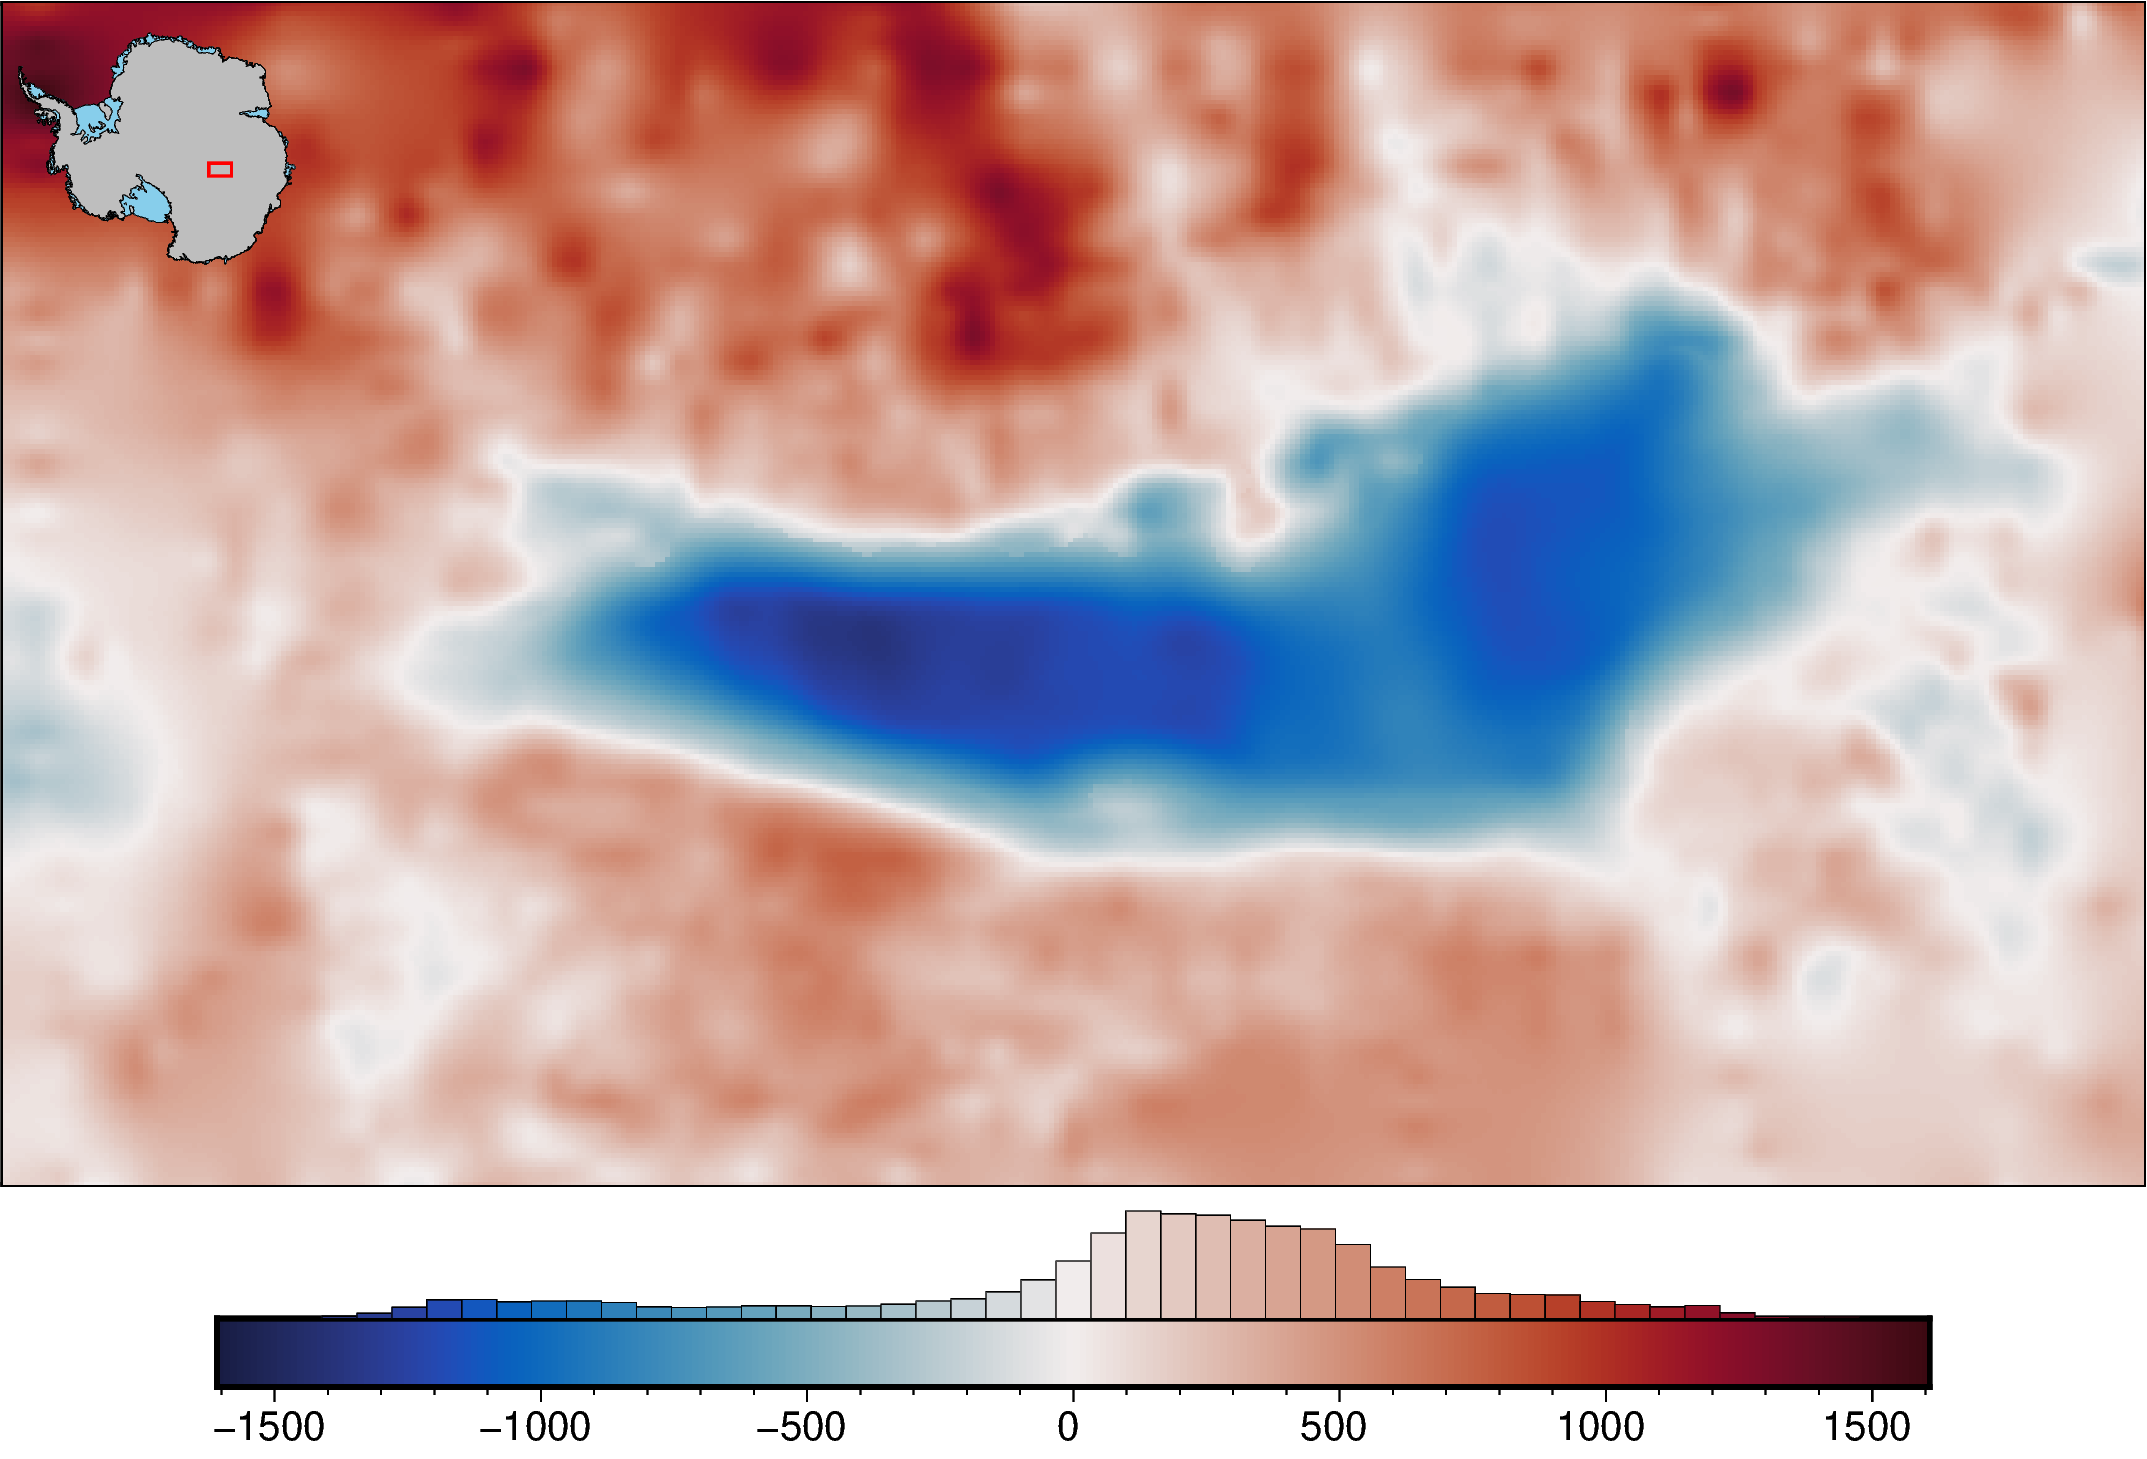

In [11]:
fig = maps.plot_grd(
    bed,
    inset=True,
    hist=True,
    cmap="balance+h0",
    cpt_lims=utils.get_min_max(bed, absolute=True),
)

fig.show(dpi=200)

### Subset region limits
Use a subset region to define the limits

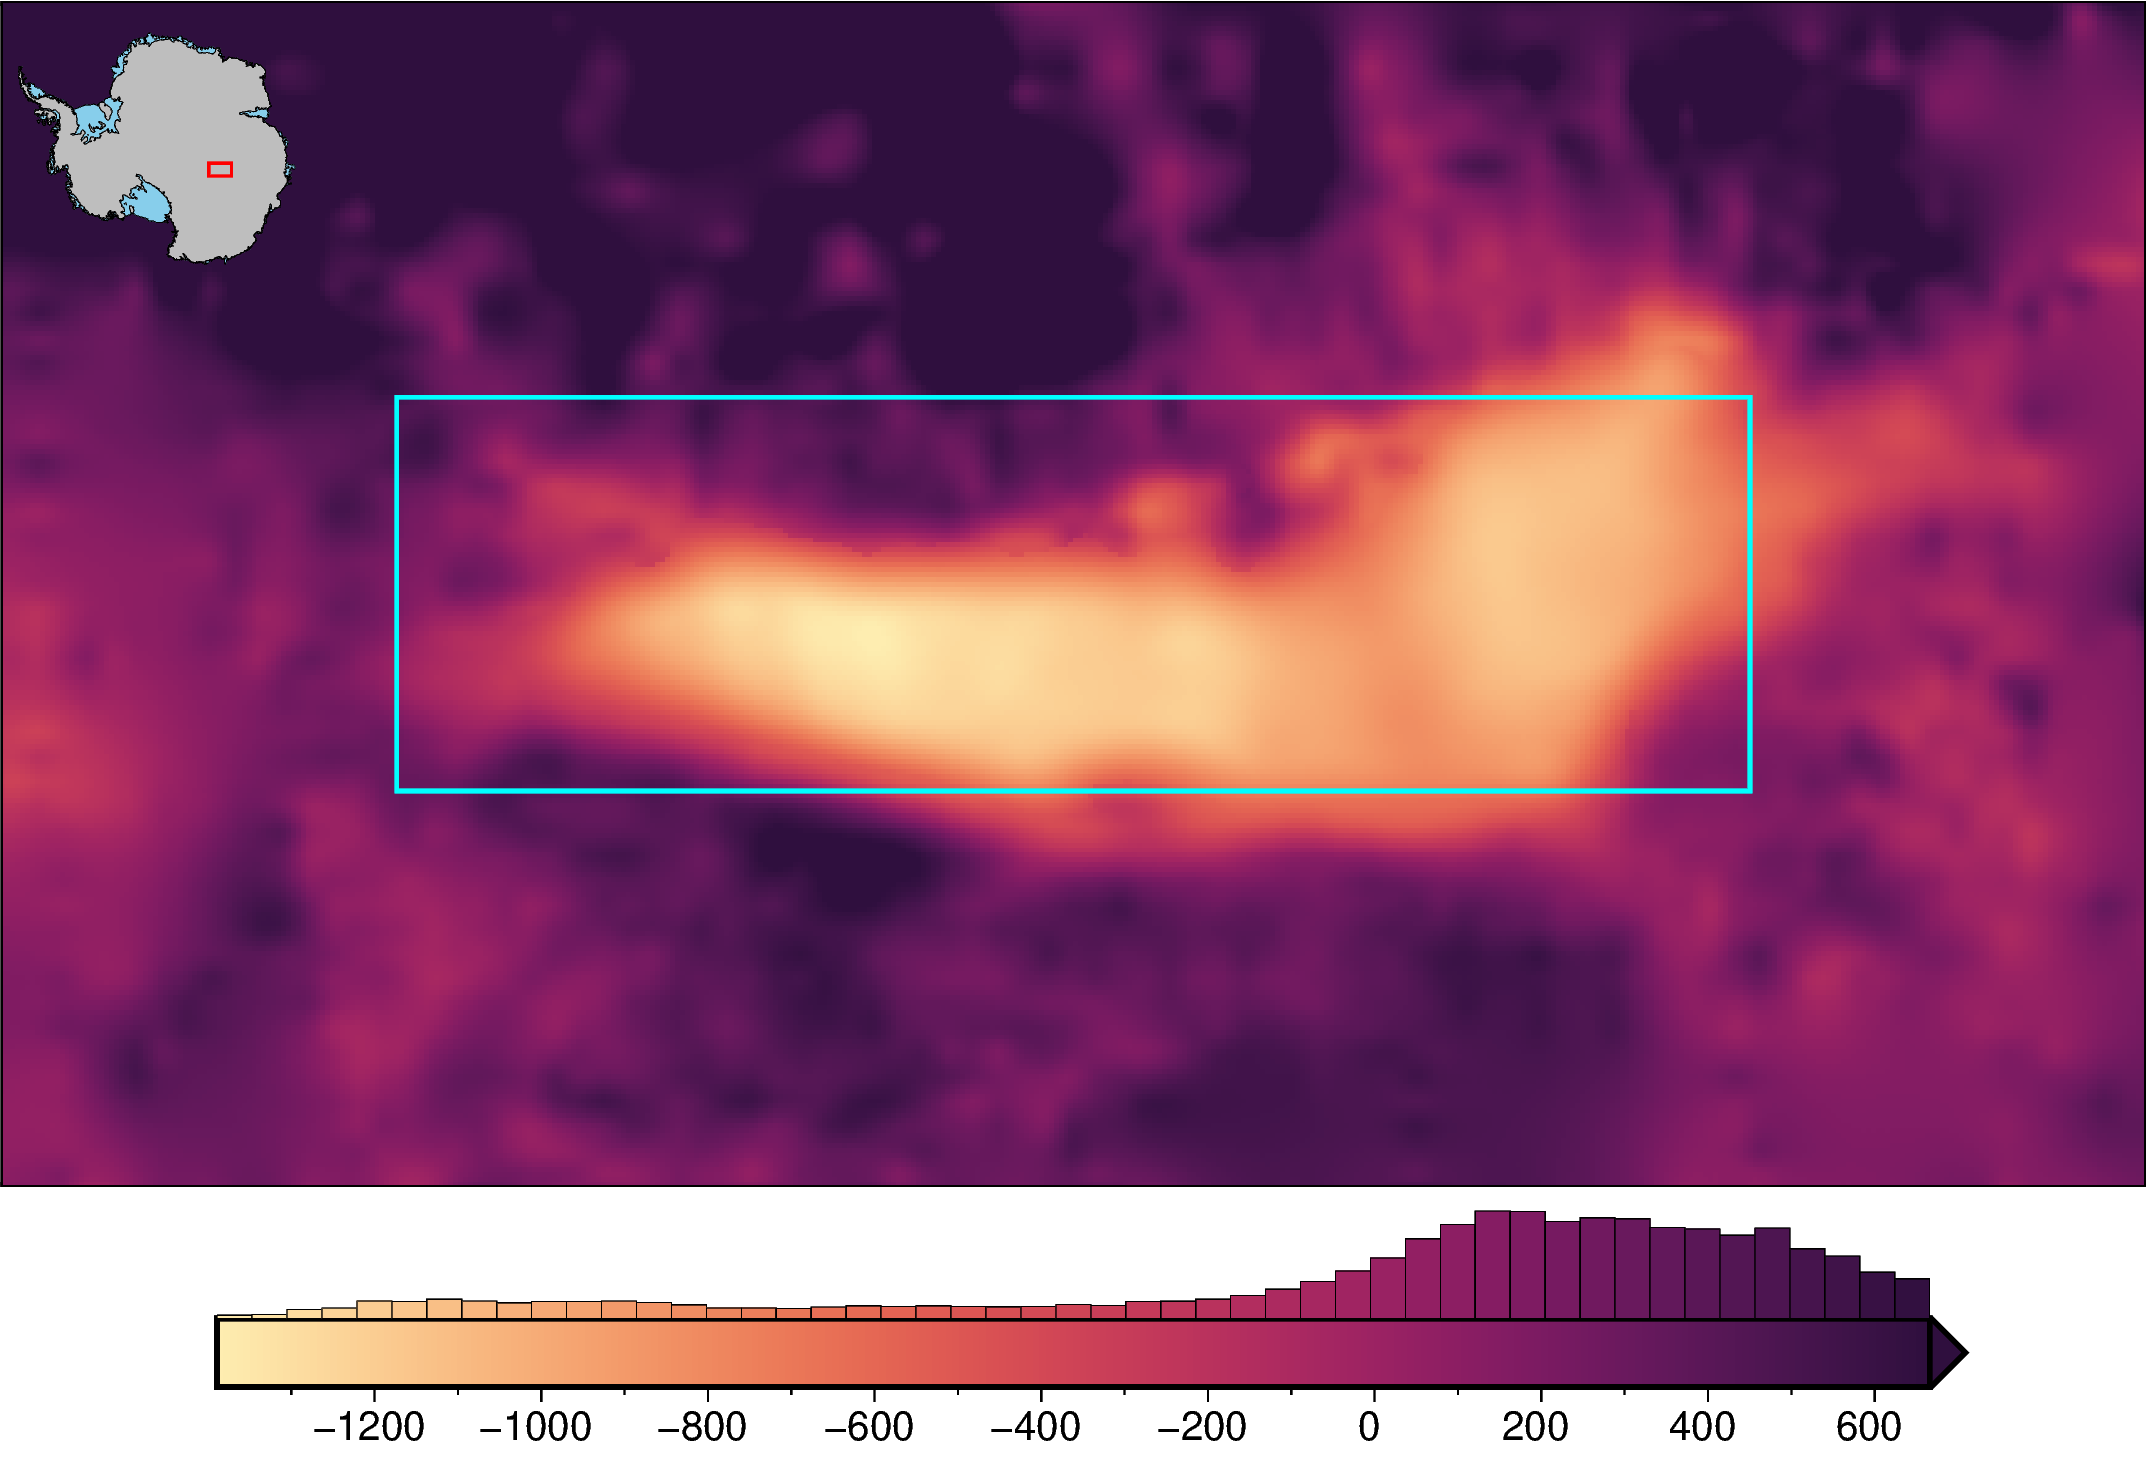

In [12]:
subset_region = regions.alter_region(regions.lake_vostok, zoom=80e3)

fig = maps.plot_grd(
    bed,
    inset=True,
    hist=True,
    cmap="matter",
    cmap_region=subset_region,  # set the colorscale based on a subset region
    # robust=True, # cmap_region can be combined with robust
    show_region=subset_region,  # show subset region
    region_pen="1.5p,cyan",  # pen for box
)

fig.show(dpi=200)

### Masked grid limits
Define limits with values within a shapefile area

In [13]:
# create a shapefile surrounding lake vostok
mask = fetch.bedmap2(
    layer="lakemask_vostok",
    region=regions.lake_vostok,
)
mask_df = vd.grid_to_table(mask).dropna()
mask_gdf = gpd.GeoDataFrame(mask_df, geometry=gpd.points_from_xy(mask_df.x, mask_df.y))
mask_gdf = mask_gdf.dissolve(by="z").concave_hull(ratio=0.1)
mask_gdf = gpd.GeoDataFrame(geometry=mask_gdf)

/home/sungw937/miniforge3/envs/polartoolkit/lib/python3.12/site-packages/pyogrio/geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


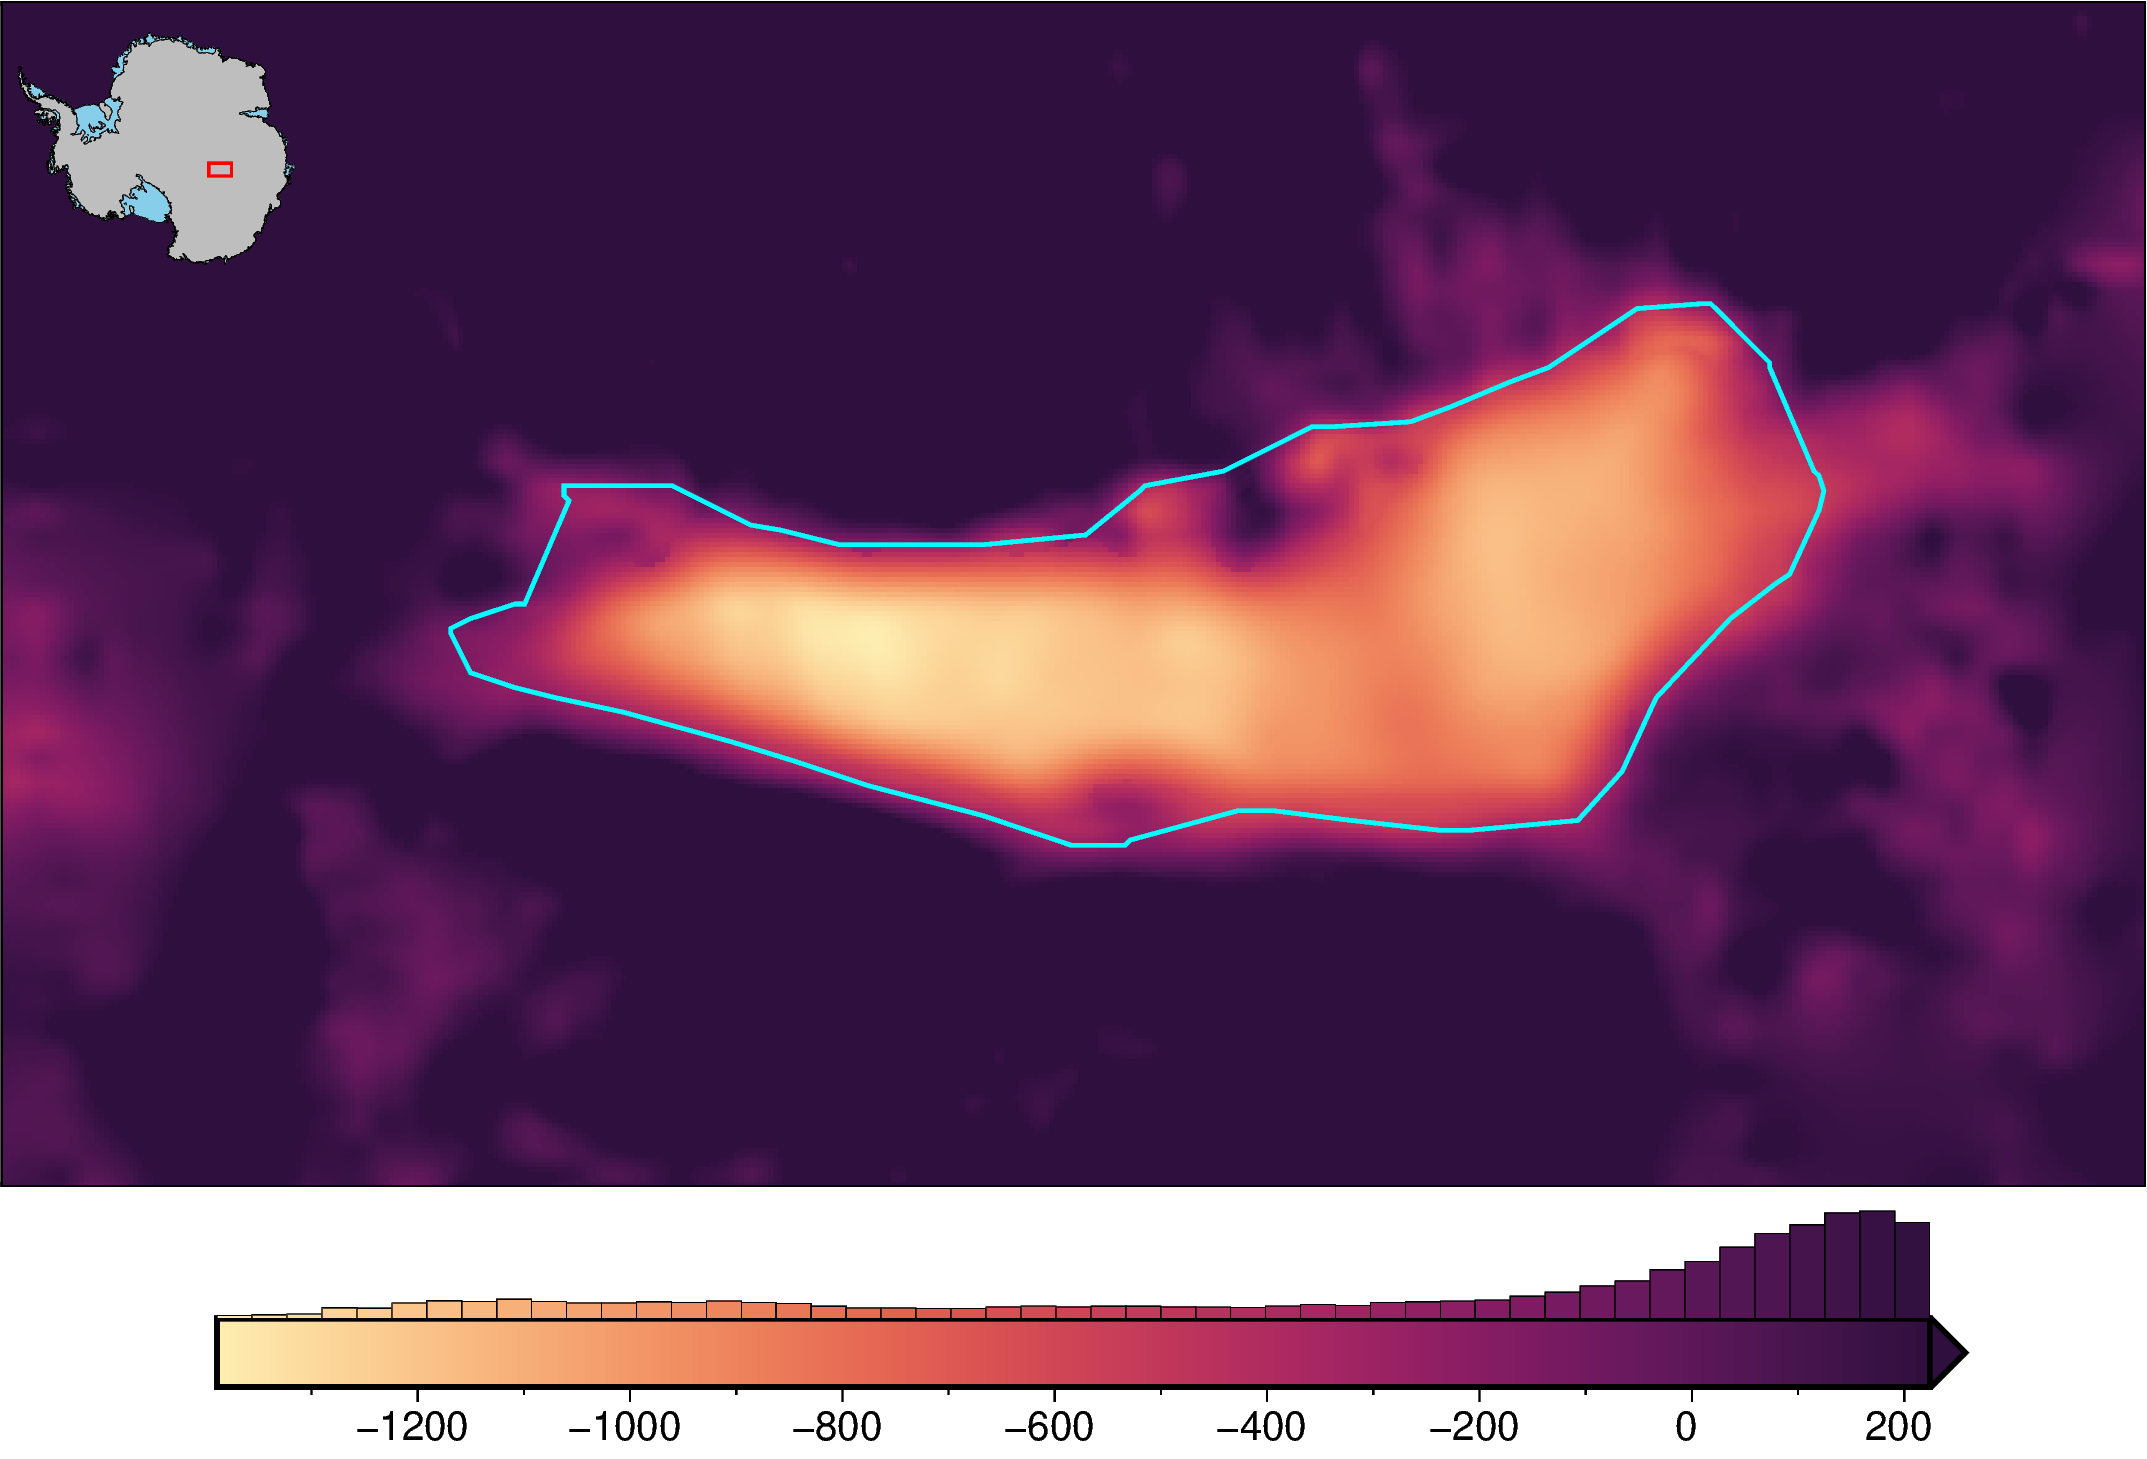

In [14]:
fig = maps.plot_grd(
    bed,
    inset=True,
    hist=True,
    cmap="matter",
    shp_mask=mask_gdf,  # use a grid values contained within a shapefile to set the
    # color limits
    # robust=True, # shp_mask can be combined with robust
)

fig.plot(
    mask_gdf,
    pen="1.5p,cyan",
)

fig.show(dpi=200)

## Colormap equalization
You can use the argument `grd2cpt` to use PyGMT's grd2cpt function to equalize the colorbar to the data distribution.

grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


/home/sungw937/polartoolkit/src/polartoolkit/maps.py:904: UserWarning: getting max/min values from grid/points since cpt_lims were not supplied, if cpt_lims were used to create the colorscale, pass them there or else histogram will not properly align with colorbar!
  self.add_colorbar(


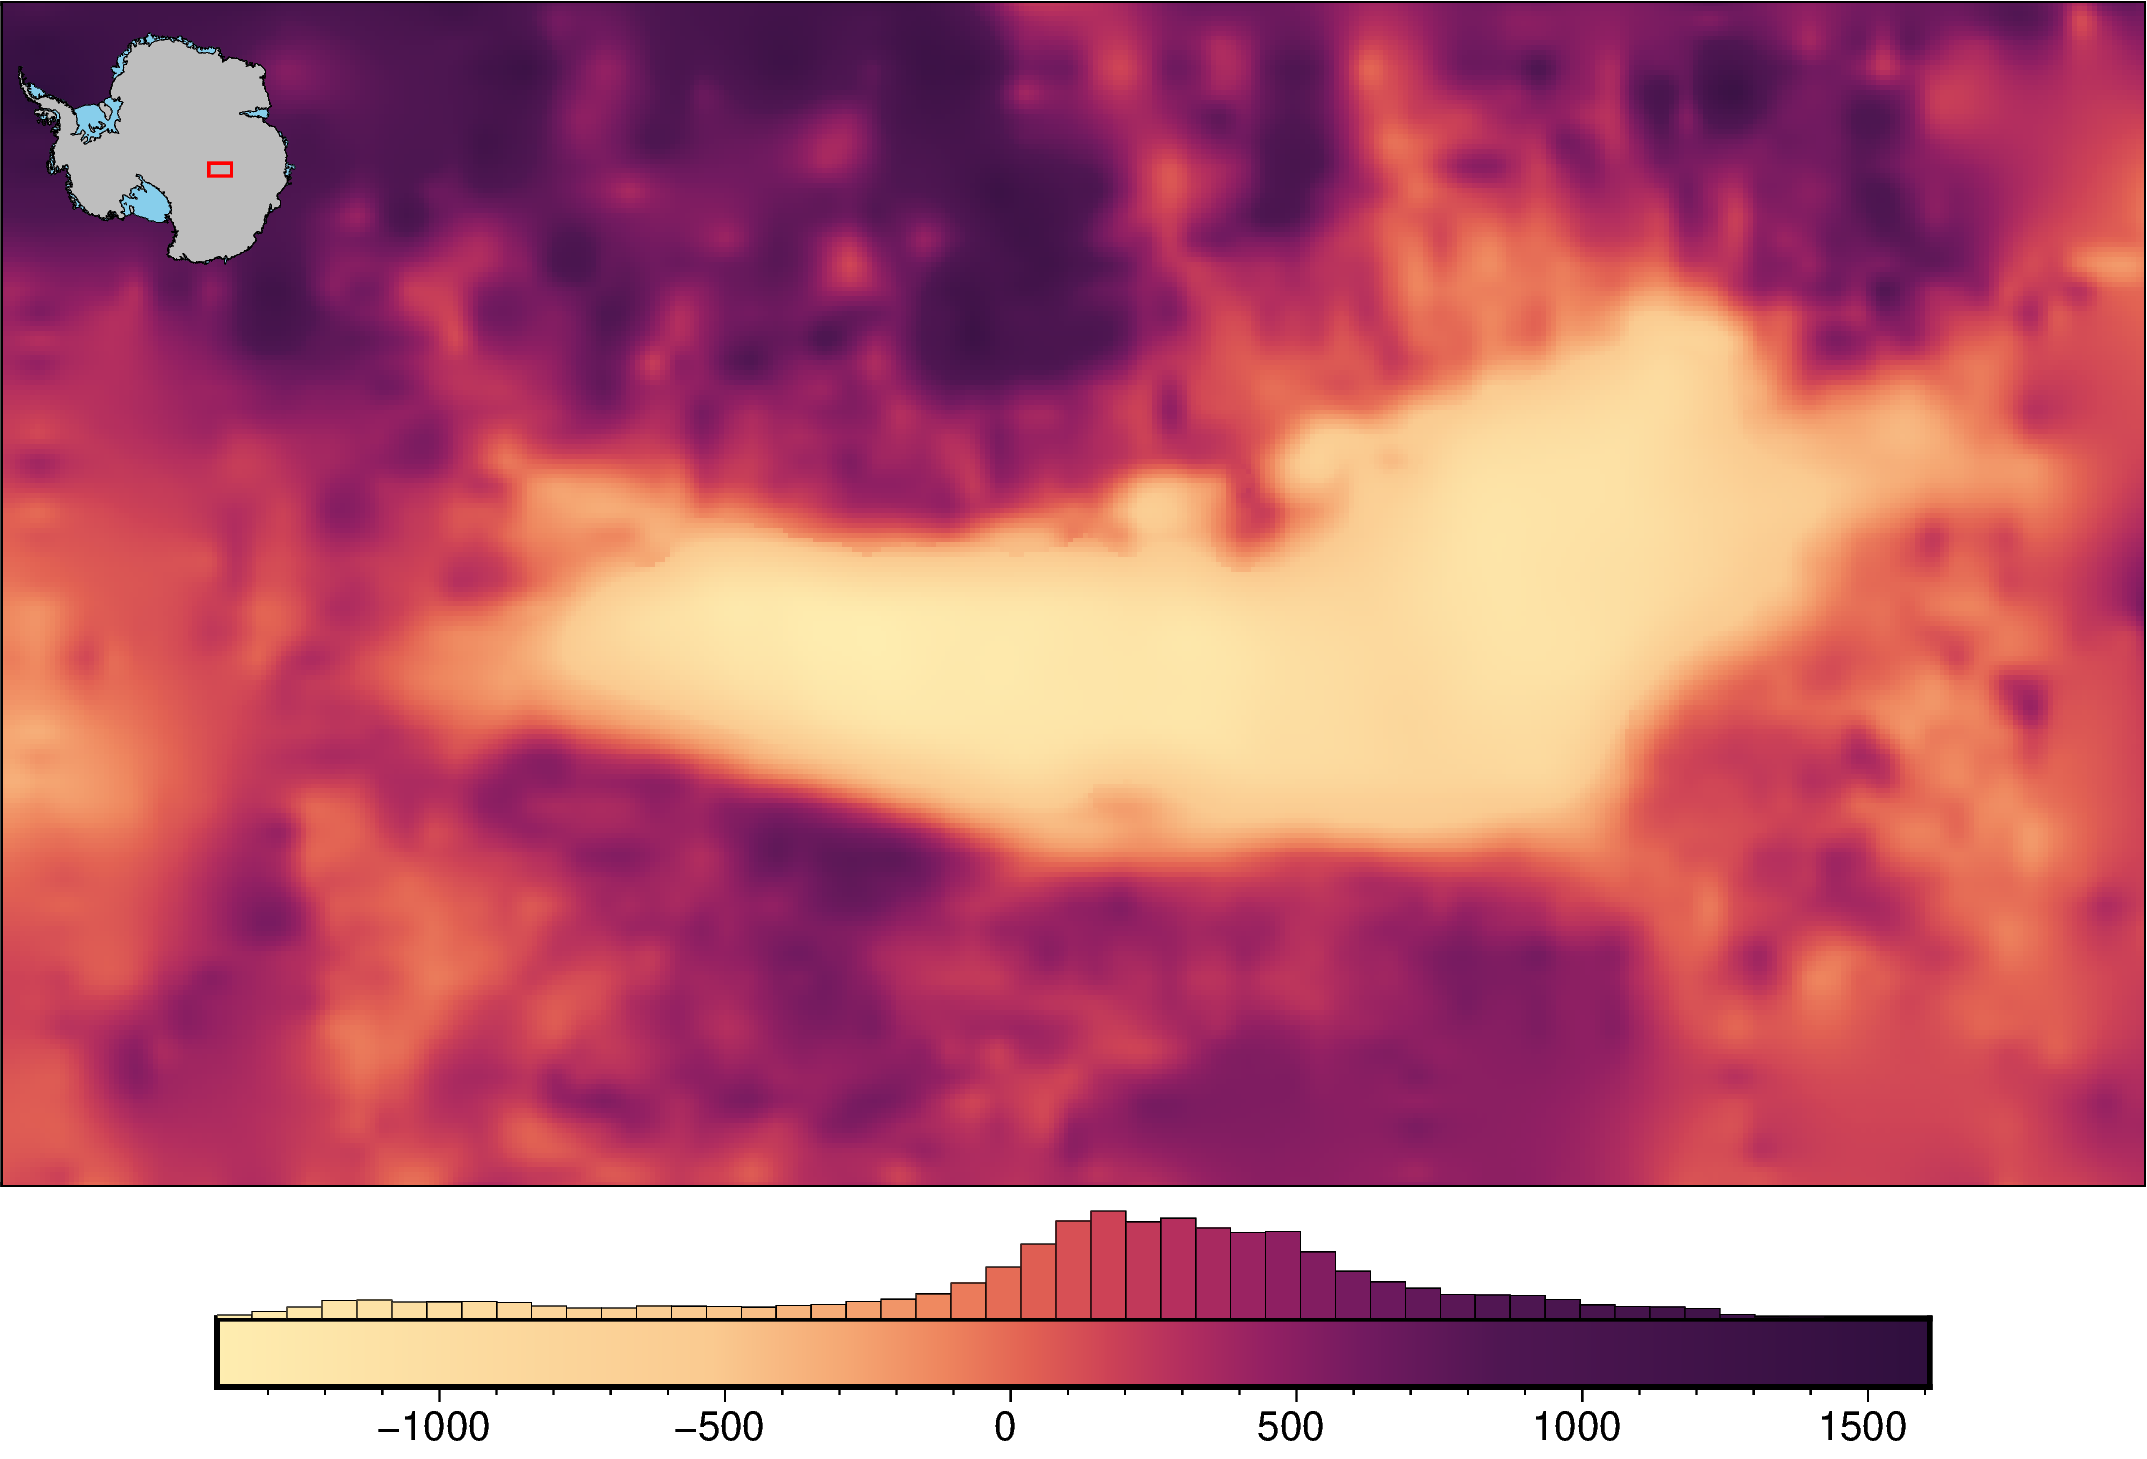

In [15]:
fig = maps.plot_grd(
    bed,
    inset=True,
    hist=True,
    cmap="matter",
    grd2cpt=True,
    # can combine with the following arguments
    # cpt_lims,
    # robust,
    # cmap_region,
    # shp_mask,
)

fig.show(dpi=200)

## Shading
You can use the argument `shading` to add a light source to show the shadows of features. This can be used automatically with `shading=True`, or can be customized by using the string format for the PyGMT shading parameter. For this, you can include "+a`azimuth`" where `azimuth` is the direction of illumination, "+m`ambient`" where `ambient` is a positive or negative number controlling the lightness of the shading, or "+n`normalization`" where `normalization` can be blank, `e`, or `t`, followed by a positive float (default of 1) to control the intensity.

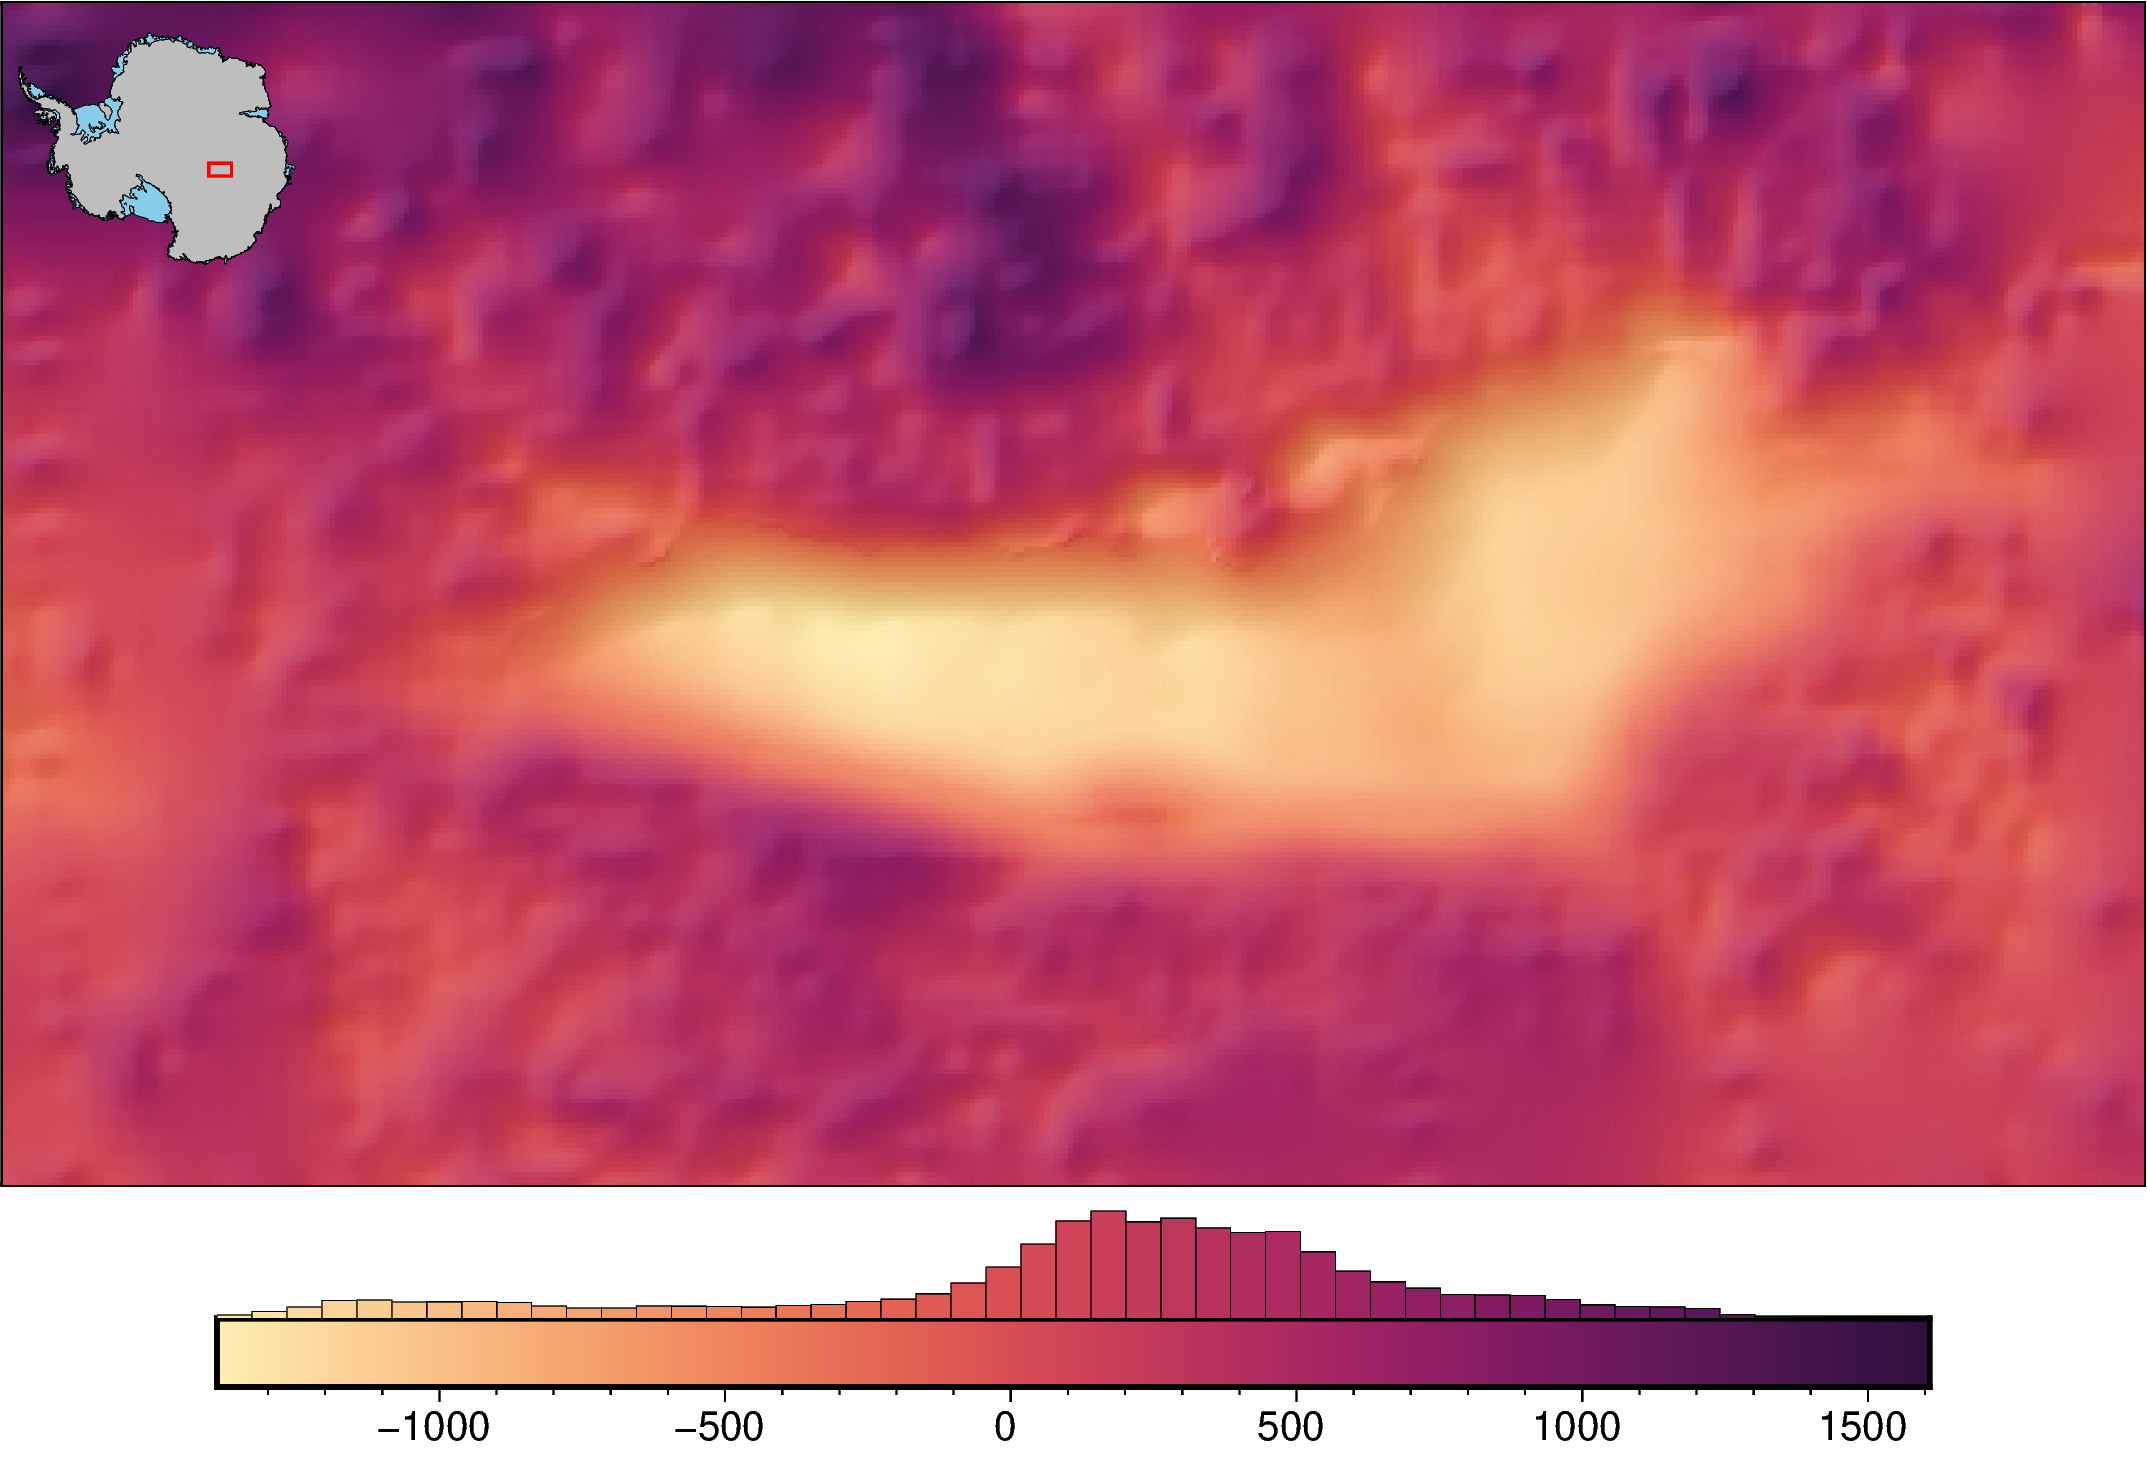

In [16]:
fig = maps.plot_grd(
    bed,
    inset=True,
    hist=True,
    cmap="matter",
    shading="+nt.2",  # or True for default shading
)

fig.show(dpi=200)

## Colorbar histogram

By setting 'hist'=True in the plotting functions, you we automatically generate a histogram of grid or point values on top of the colobar. Below we should a few of the options to customize this.

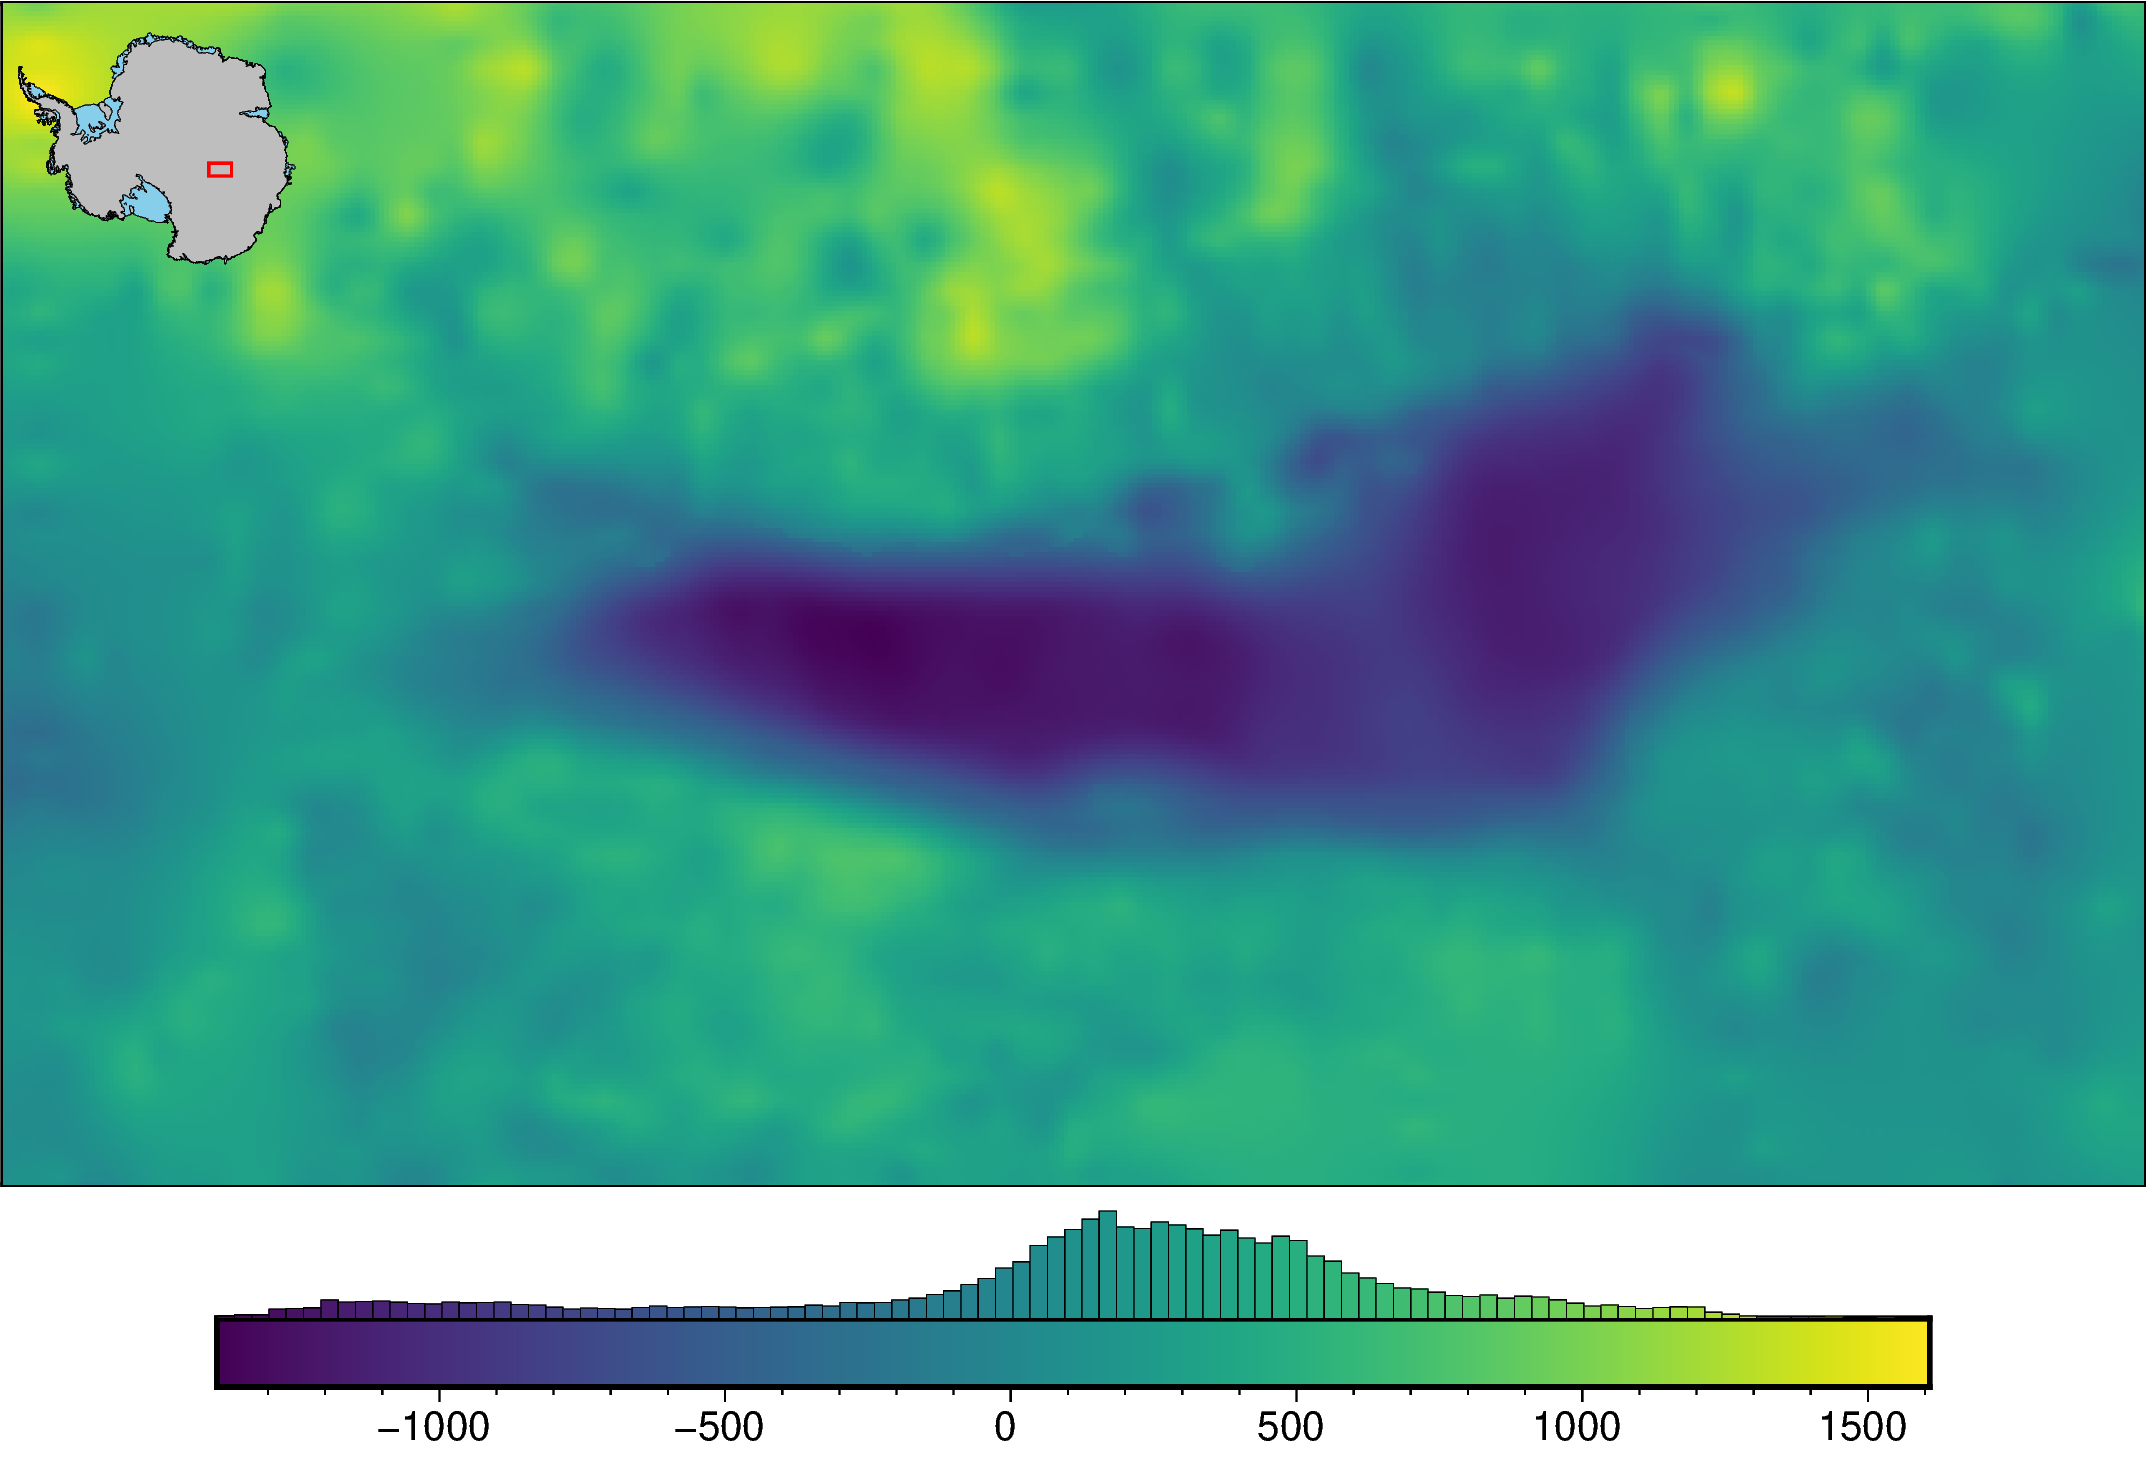

In [17]:
fig = maps.plot_grd(
    bed,
    inset=True,
    hist=True,
    hist_bin_num=100,  # set the number of bins in the histogram
)

fig.show(dpi=200)

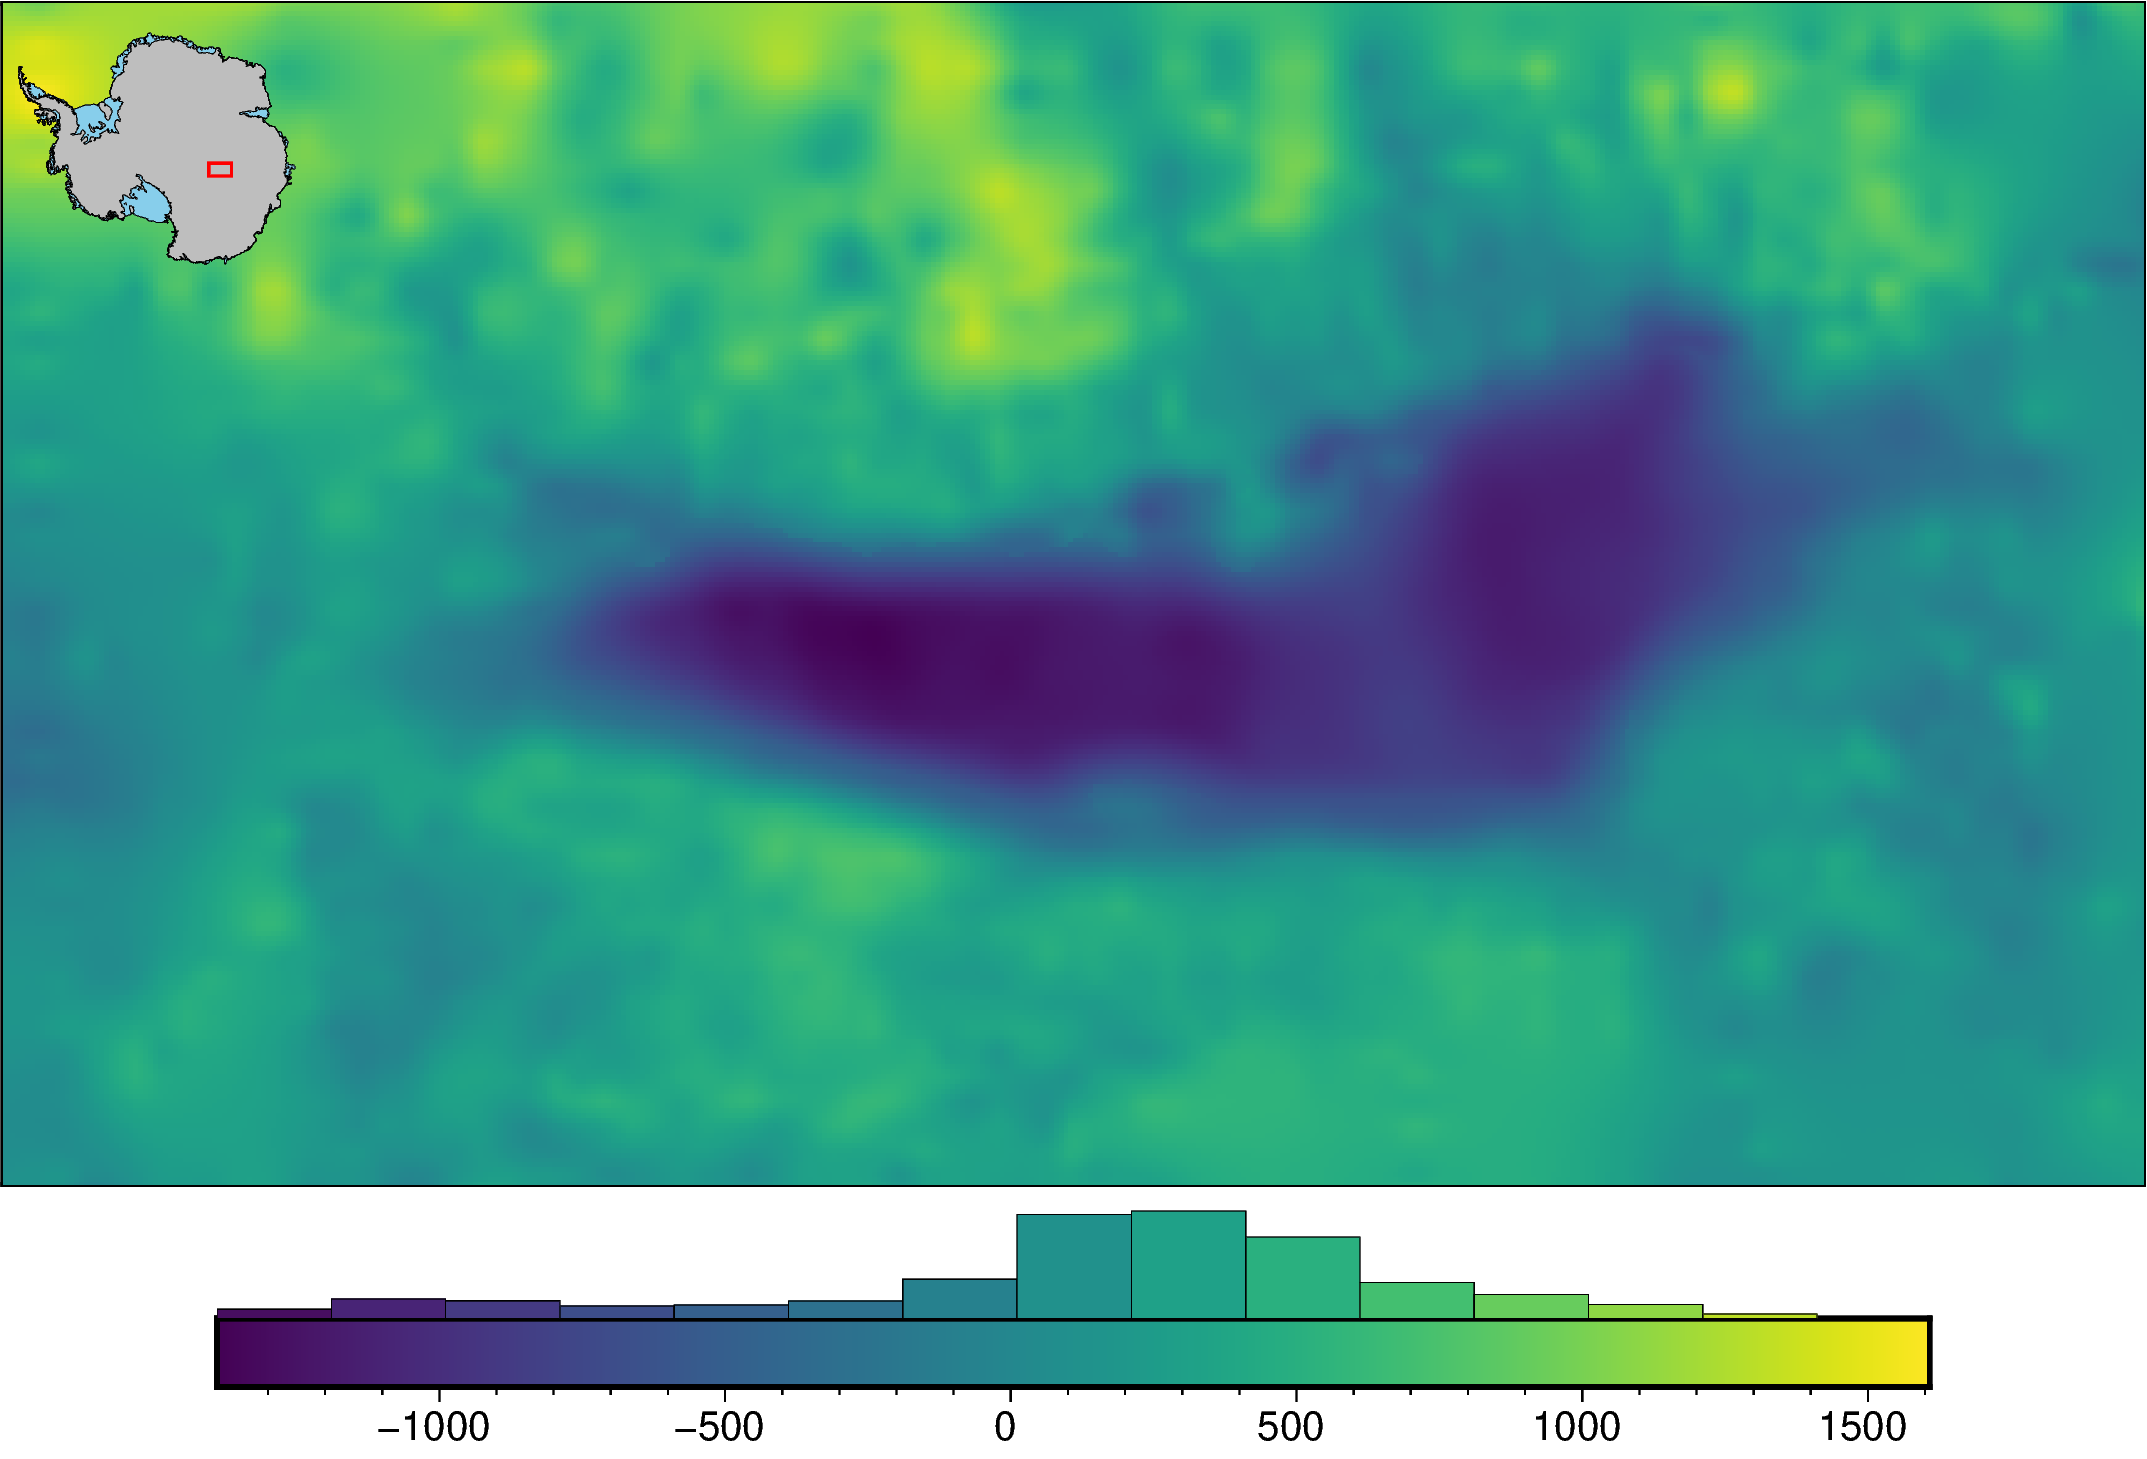

In [18]:
fig = maps.plot_grd(
    bed,
    inset=True,
    hist=True,
    hist_bin_width=200,  # set the size of the bins in the histogram
)

fig.show(dpi=200)

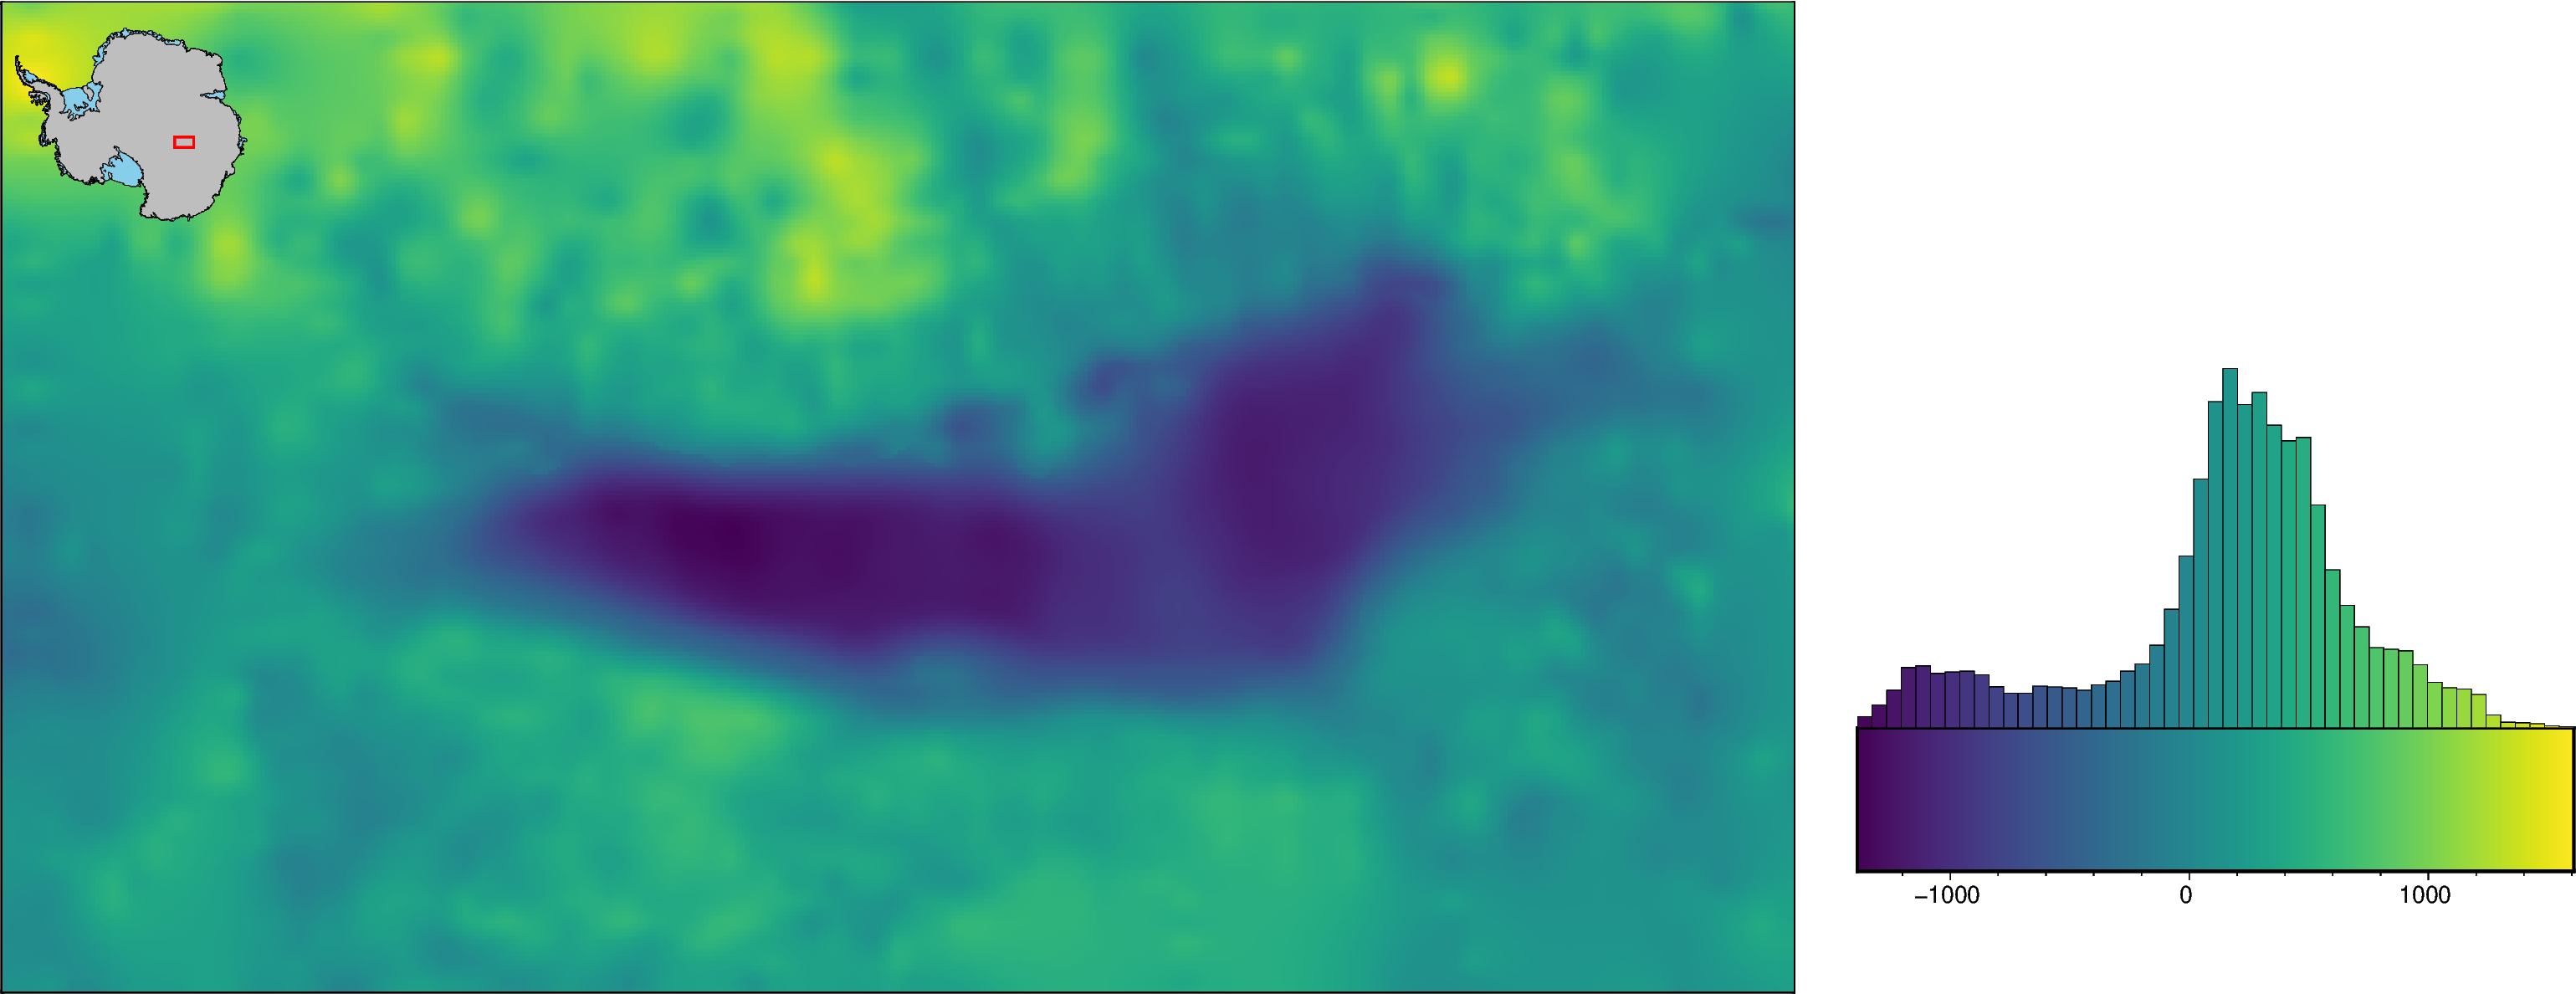

In [19]:
fig = maps.plot_grd(
    bed,
    inset=True,
    hist=True,
    cbar_width_perc=0.4,  # set the width of the colorbar as a percentage of figure size
    cbar_height_perc=0.2,  # set the height as a percentage of cbar width
    cbar_hist_height=6,  # height of the histogram in cm
    cbar_yoffset=-4,  # offset the colorbar from the bottom of the figure in cm
    cbar_xoffset=20,  # offset the colorbar from the left of the figure in cm
)

fig.show(dpi=200)